## Import the Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
sns.set_style('whitegrid')
sns.set_context("talk")
import scipy
import joblib
import missingno as msno
from datetime import datetime

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, LabelBinarizer
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ndcg_score, dcg_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import utils

import tensorflow as tf
import tensorflow_ranking as tfr

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

## Loading the Data and Look at the big Picture

In [3]:
## Loading both train and test csv files
df_train = pd.read_csv('datasets/train_users_2/train_users_2.csv')
df_test = pd.read_csv('datasets/test_users/test_users.csv')

## Check shapes for datasets
print('Shape of train dataset is --', df_train.shape)
print('Shape of test dataset is --', df_test.shape)

Shape of train dataset is -- (213451, 16)
Shape of test dataset is -- (62096, 15)


In [4]:
## The Label (target) for full training Dataset
y_full_train = df_train['country_destination']

## Exploratory Data Analysis, Data Exploration & Preparation

### `Concatenate both train and test Datasets for EDA`

In [5]:
## concatenate the datasets for EDA
df_total = pd.concat((df_train, df_test), axis=0, ignore_index=True)

## shape of them
print('Shape of all Dataset is --', df_total.shape)

## show the head of training dataset
df_total.head()

Shape of all Dataset is -- (275547, 16)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


### `Using missingno library to get the Null values in bar or matrix`

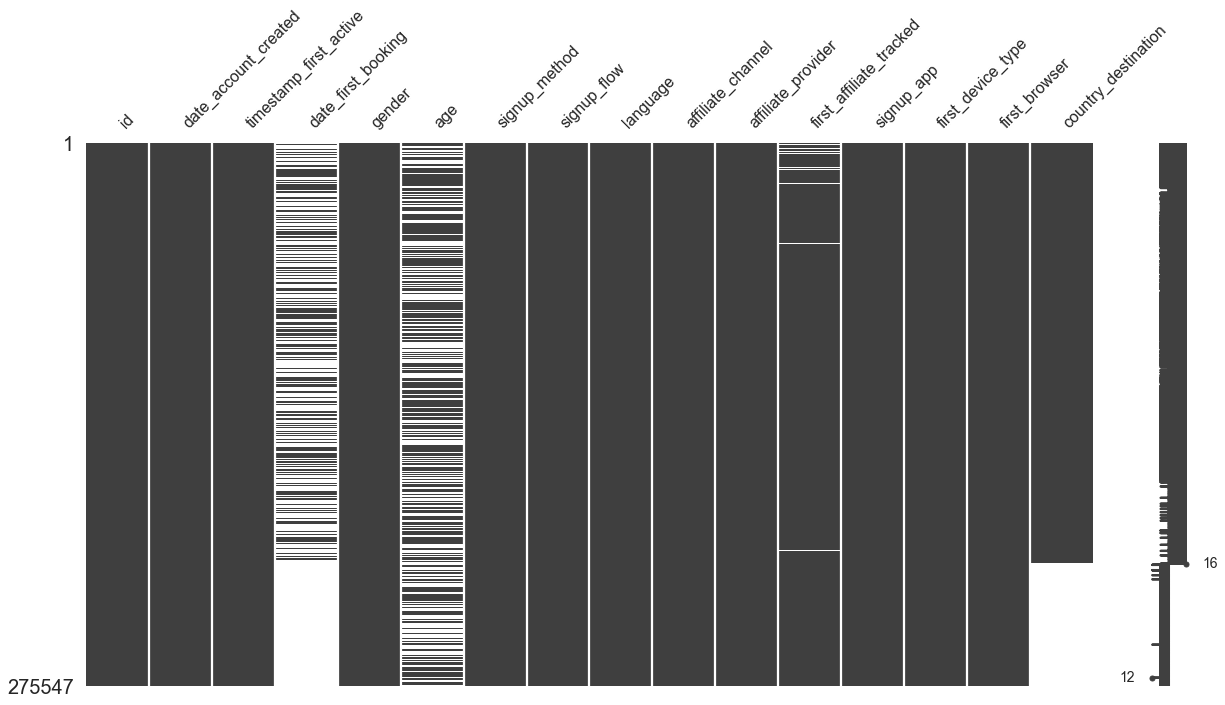

In [6]:
## Let's check nulls
msno.matrix(df_total, figsize=(20, 10));    

## Alot of nulls in (age, country_destination, date_first_booking)

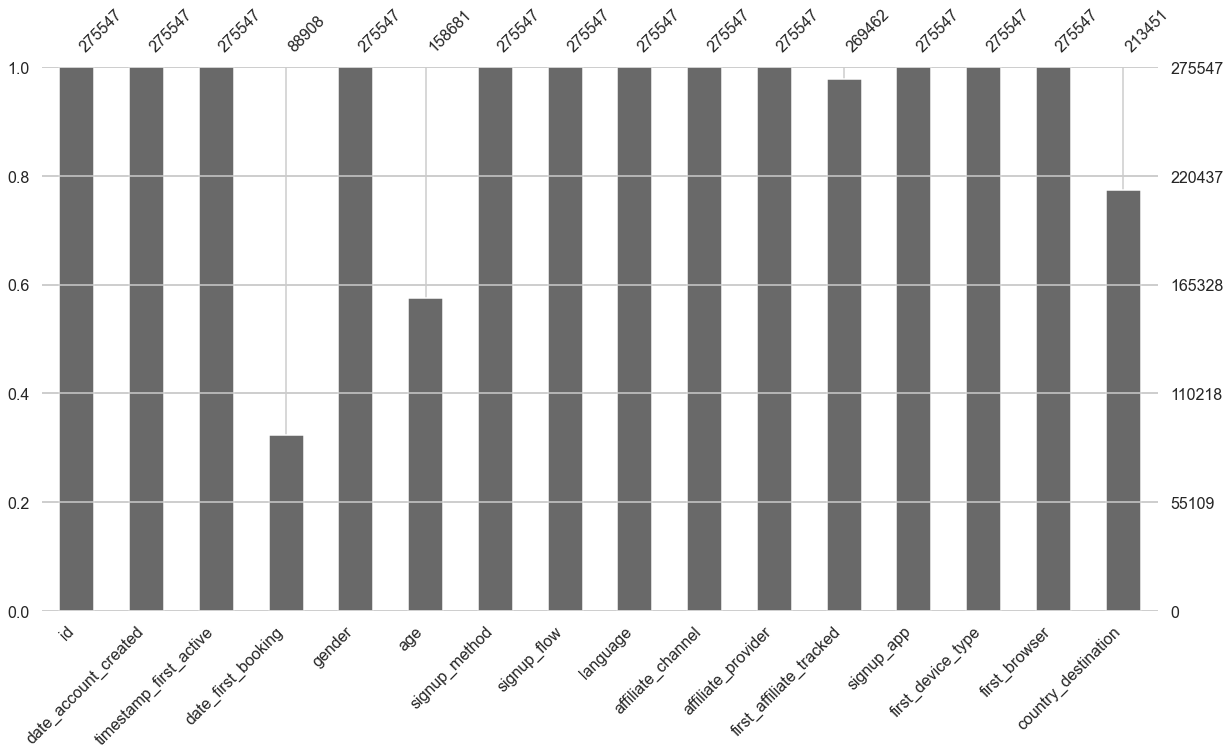

In [7]:
## Let's check nulls
msno.bar(df_total, figsize=(20, 10));    ## Alot of nulls in (age, country_destination, date_first_booking)

### `Define a Function to get the Nulls at each column in the df_total`

In [8]:
## Get Number of nulls in each columns

def null_columns_func(df):
    ''' This Function tries to get the columns containing null values and sum of nulls in each column
    Args:
    ----M
        (df: DataFrame) : the DataFrame required to be processed
        
    Returns:
    -------
        (null_dict : Dictionary) : returns a dictionary , key is the name of column, value is the sum of nulls
    '''
    null_dict = {}
    for col in df.columns:
        ## to return only the columns if null values > 0 and what are these columns 
        null_values = df[col].isnull().sum()
        if null_values > 0:
            null_dict[col]=null_values
    return null_dict

In [9]:
## Call the function and  check again
null_values_before = null_columns_func(df_total)   
null_values_before

{'date_first_booking': 186639,
 'age': 116866,
 'first_affiliate_tracked': 6085,
 'country_destination': 62096}

In [10]:
## Let's drop (id, country_destination, date_first_booking)
df_total = df_total.drop(columns=['id', 'country_destination', 'date_first_booking'], axis=1)

df_total.shape

(275547, 13)

In [11]:
## Call the function and get check again
null_values_after = null_columns_func(df_total)   ## ok that what I want
null_values_after

{'age': 116866, 'first_affiliate_tracked': 6085}

In [12]:
## Check unique value for each column

for col in df_total.columns:
    if df_total[col].dtype not in ['int32', 'int64', 'float32', 'float64']:
        print(f'{col} :')
        print(df_total[col].unique())
        print('**'*30)

date_account_created :
['2010-06-28' '2011-05-25' '2010-09-28' ... '2014-09-28' '2014-09-29'
 '2014-09-30']
************************************************************
gender :
['-unknown-' 'MALE' 'FEMALE' 'OTHER']
************************************************************
signup_method :
['facebook' 'basic' 'google' 'weibo']
************************************************************
language :
['en' 'fr' 'de' 'es' 'it' 'pt' 'zh' 'ko' 'ja' 'ru' 'pl' 'el' 'sv' 'nl'
 'hu' 'da' 'id' 'fi' 'no' 'tr' 'th' 'cs' 'hr' 'ca' 'is' '-unknown-']
************************************************************
affiliate_channel :
['direct' 'seo' 'other' 'sem-non-brand' 'content' 'sem-brand'
 'remarketing' 'api']
************************************************************
affiliate_provider :
['direct' 'google' 'other' 'craigslist' 'facebook' 'vast' 'bing' 'meetup'
 'facebook-open-graph' 'email-marketing' 'yahoo' 'padmapper' 'gsp' 'wayn'
 'naver' 'baidu' 'yandex' 'daum']
****************************

### `Statistics for columns`

In [13]:
## some statistical information
df_total.describe()

,timestamp_first_active,age,signup_flow
count,2.755470e+05,158681.000000,275547.000000
mean,2.013310e+13,47.145310,4.291965
std,9.146438e+09,142.629468,8.794313
min,2.009032e+13,1.000000,0.000000
25%,2.013040e+13,28.000000,0.000000
50%,2.014010e+13,33.000000,0.000000
75%,2.014062e+13,42.000000,1.000000
max,2.014093e+13,2014.000000,25.000000


In [14]:
## Check the information for datatypes and null also
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date_account_created     275547 non-null  object 
 1   timestamp_first_active   275547 non-null  int64  
 2   gender                   275547 non-null  object 
 3   age                      158681 non-null  float64
 4   signup_method            275547 non-null  object 
 5   signup_flow              275547 non-null  int64  
 6   language                 275547 non-null  object 
 7   affiliate_channel        275547 non-null  object 
 8   affiliate_provider       275547 non-null  object 
 9   first_affiliate_tracked  269462 non-null  object 
 10  signup_app               275547 non-null  object 
 11  first_device_type        275547 non-null  object 
 12  first_browser            275547 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 27.3+ MB


> ### Comment: Until now, it seems that Dataset is very messy and (age) column in full of missing values and unreasonable values, and most of the datatypes aren't True 

-------------

## Data Visualization & Preprocessing

### `Univariate Visualization`

### `Let's examine "Age" Feature`

In [15]:
## check the statistics
df_total['age'].describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

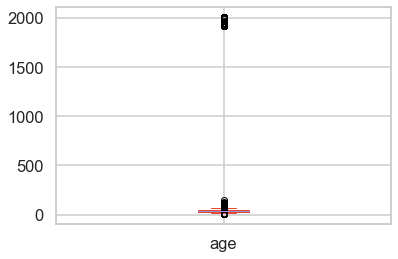

In [16]:
## box plot ---> there is a huge outlier (above and below)
df_total['age'].plot(kind='box');

`Huge Outliers (Mistakes here), Let's make the age range for person to book a ticket is (15-100) year ` <br />
`By Seraching via the Internet, I found that minimum age for person to be alone in a travle is about 15 years old` <br />
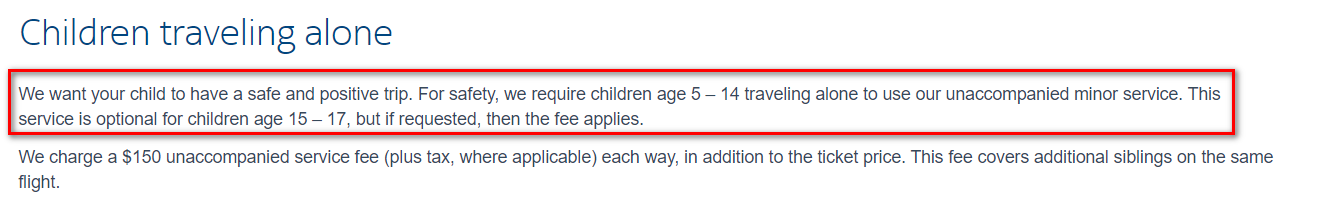

In [17]:
## Handle the age to be nan if it is bigger than 100 years or less than 15 years
df_total[df_total['age']>=100]=np.nan
df_total[df_total['age']<15]=np.nan

count    155901.000000
mean         36.042328
std          11.629913
min          15.000000
25%          28.000000
50%          33.000000
75%          42.000000
max          99.000000
Name: age, dtype: float64



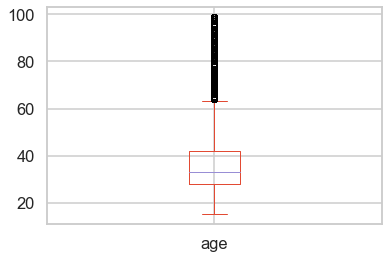

In [18]:
## check the statistics and box plot again
## check the statistics
stas_age = df_total['age'].describe()
print(stas_age)
print()
## box plot ---> 
df_total['age'].plot(kind='box');    ## Great that What I want to do

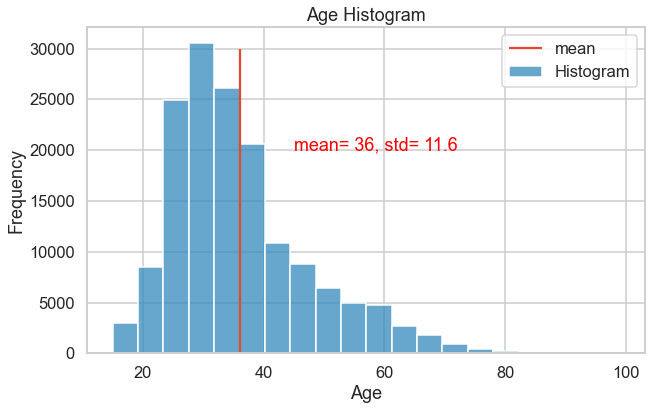

In [19]:
## we can also see the distribution of age as Histogram
## Histogram for age

mean_age = df_total['age'].mean()
std_age = df_total['age'].std()
plt.figure(figsize=(10, 6))
plt.vlines(x=mean_age, ymin=0, ymax=30000, label='mean')
plt.text(s=f'mean= {mean_age:.0f}, std= {std_age:.1f}', x=45, y=20000, color='red')

sns.histplot(x='age', data=df_total, bins=20, label='Histogram')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Histogram')
plt.legend()
plt.show()

> ### Comment: Age Feature is messy and full of unreasonable values, I handled it by making the minimum value of age to be 15 years and max value to be less than 100 years, also the mean of age is about 36 years with std about 11.7 year

### `What about cutting age Feature into intervals (bins)`

In [20]:
## Cutting the age feature into bins (intervals)
df_total['age_bins'] = pd.cut(df_total['age'], 
                              bins=[15, 20, 30, 40, 50, 60, 70, 80, 90, np.inf], 
                              labels=['15-20','20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])

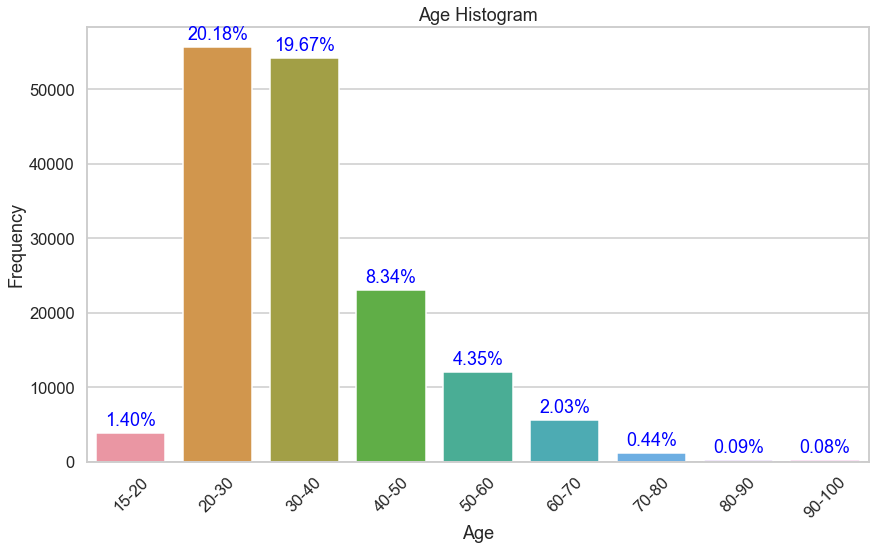

In [21]:
## Countplot to know whic interval is more in Dataset
plt.figure(figsize=(14, 8))

order_age_bins = df_total['age_bins'].value_counts().sort_index()

sns.countplot(x='age_bins', data=df_total, order=order_age_bins.index)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Age Histogram')


for i in range(order_age_bins.shape[0]):
    count = order_age_bins[i]
    strt='{:0.2f}%'.format(100*count / df_total.shape[0])
    plt.text(i, count+1000, strt, ha='center', color='blue')

> ### Comment: It seems that people in range (20-40) is much more active than other people in different intervals 

---

### `Let's examine "Destination" Feature`
`Note : This Feature is only avilable in df_train as it is the target`

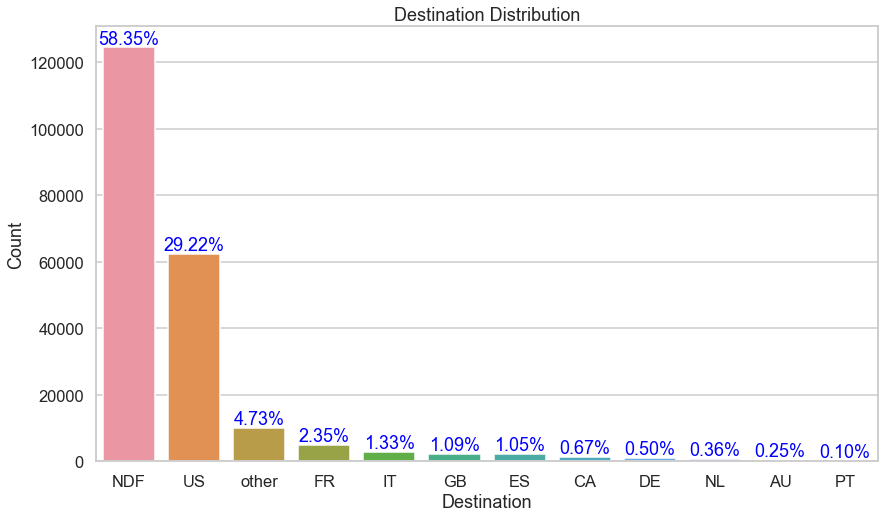

In [22]:
## Finding Destination Distribution. --> in train Dataset
plt.figure(figsize=(14, 8))

dest_order = df_train['country_destination'].value_counts()
sns.countplot(data=df_train, x='country_destination', order=dest_order.index)
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Destination Distribution')

for i in range(dest_order.shape[0]):
    count = dest_order[i]
    strt='{:0.2f}%'.format(100*count / df_train.shape[0])
    plt.text(i, count+1000, strt, ha='center', color='blue')

> ### Comment: It seems that the majority of people don't book a ticket and there is No Destination Found (NDF), and about 29% of people book a ticket in the US as the Dataset is for users in US, people tends to travel locally, about 4.7% book to an unknown destination, and the next known country is France after the US with a percentage about 2.3%

---------

### `Let's examine "Gender" Feature`

In [23]:
## Let's see what the distribution of Gender
df_total['gender'].value_counts()

-unknown-    128637
FEMALE        76414
MALE          67385
OTHER           331
Name: gender, dtype: int64

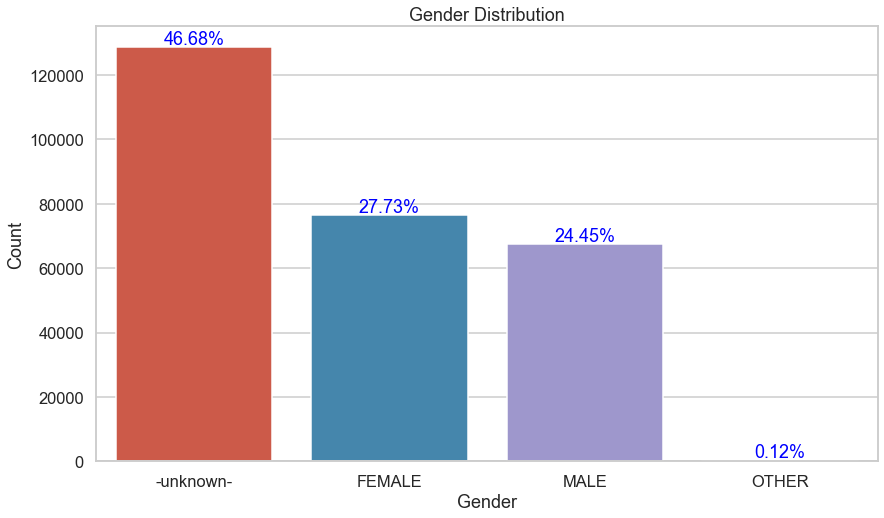

In [24]:
## Gender Distribution in the Whole Dataset
plt.figure(figsize=(14, 8))

gen_order = df_total['gender'].value_counts()
sns.countplot(x='gender', data=df_total, order=gen_order.index)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')

for i in range(gen_order.shape[0]):
    count = gen_order[i]
    strt='{:0.2f}%'.format(100*count / df_total.shape[0])
    plt.text(i, count+1000, strt, ha='center', color='blue')

> ### Comment: It seems that the majority of people don't register their gender because it is (unknown), and the people who register their gender about (27.7% Female, 24.5% Male, small value for other), I think most of the people are too lazy to register and In my opinion I think that Men tends to be much for (unknown) as they are too much lazy than Females, especially in these cases

----------------

## `Let's examine more Features`

## `What about examining WeekDays`

`to see which days the people are more active`

`Convert timestamp features to be (datetime)`

In [25]:
## Convert timestamp features to be (datetime)
df_total['date_account_created'] = pd.to_datetime(df_total['date_account_created'])
df_total['timestamp_first_active'] = pd.to_datetime(df_total['timestamp_first_active'], format='%Y%m%d%H%M%S')

## Get the Day of week
df_total['week_day'] = df_total['date_account_created'].dt.dayofweek
df_total['week_day']   ## 0 for Monday, start of the week and 6 for Sunday, end of the week

0         0.0
1         2.0
2         1.0
3         0.0
4         1.0
         ... 
275542    1.0
275543    1.0
275544    1.0
275545    1.0
275546    1.0
Name: week_day, Length: 275547, dtype: float64

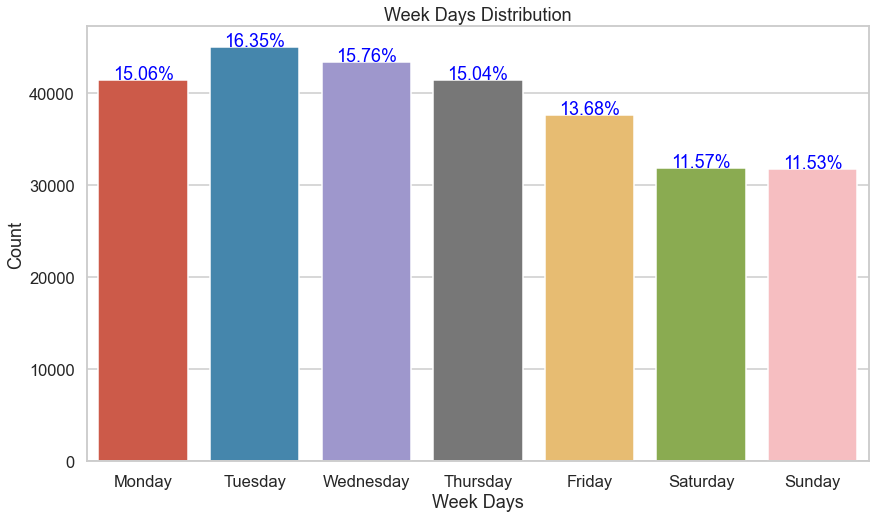

In [26]:
## to see the count plot for each day

## thid dict only o map value of numbers to names
map_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df_weeks_days = df_total['week_day'].copy()
## mapping
df_weeks_days = df_weeks_days.map(map_dict)  ## mapped to labels


## Figure
plt.figure(figsize=(14, 8))
week_order = df_total['week_day'].value_counts().sort_index()
sns.countplot(df_weeks_days, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Week Days Distribution')
plt.xlabel('Week Days')
plt.ylabel('Count')

for i in range(week_order.shape[0]):
    count = week_order[i]
    strt='{:0.2f}%'.format(100*count / df_weeks_days.shape[0])
    plt.text(i, count+100, strt, ha='center', color='blue')

> ### Comment: It seems that people are more active in the middle of the week than at the weekend, It makes some confusion, why people are active and they aren't in their weekend, In my opinion, I think people are more active in the middle of the week than at the weekend because, with the pressure and responsibilities of work, people are more active and decided to check something or book a ticket to take a breath after a bad day full of work and pressure

-----------

## `What about examining Years`

`to see which years the people are more active`

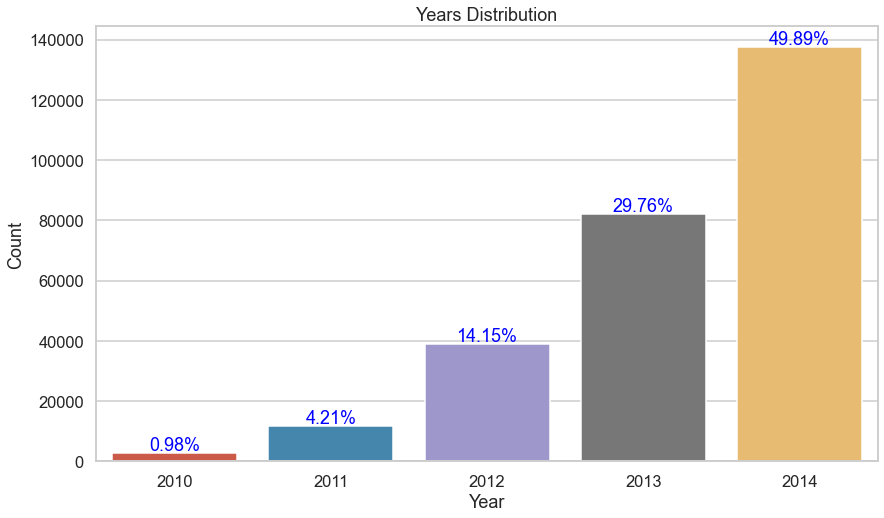

In [27]:
## Get the years
df_total['acc_year'] = df_total['date_account_created'].dt.year
df_total['acc_year'] = df_total['acc_year'].astype('category')

## only to remove decimal number after dot, 2010.0 -> 2010
df_total['acc_year'] = df_total['acc_year'].map('{0:g}'.format)     

## Figure
plt.figure(figsize=(14, 8))
year_order = df_total['acc_year'].value_counts(ascending=True)

sns.countplot(x='acc_year', data=df_total, order=year_order.index)
plt.title('Years Distribution')
plt.xlabel('Year')
plt.ylabel('Count')


for i in range(year_order.shape[0]):
    count = year_order[i]
    strt='{:0.2f}%'.format(100*count / df_total.shape[0])
    plt.text(i, count+1000, strt, ha='center', color='blue')
    

> ### Comment: It seems that people are more active with time, The site is much more popular in recent years with the spread of internet service and social media and online shopping, and more technologies

------------

### `Let's examine "signup_method" Feature`

In [28]:
## Examine the (signup_method) Feature
df_total['signup_method'].unique()

array(['facebook', 'basic', nan, 'google', 'weibo'], dtype=object)

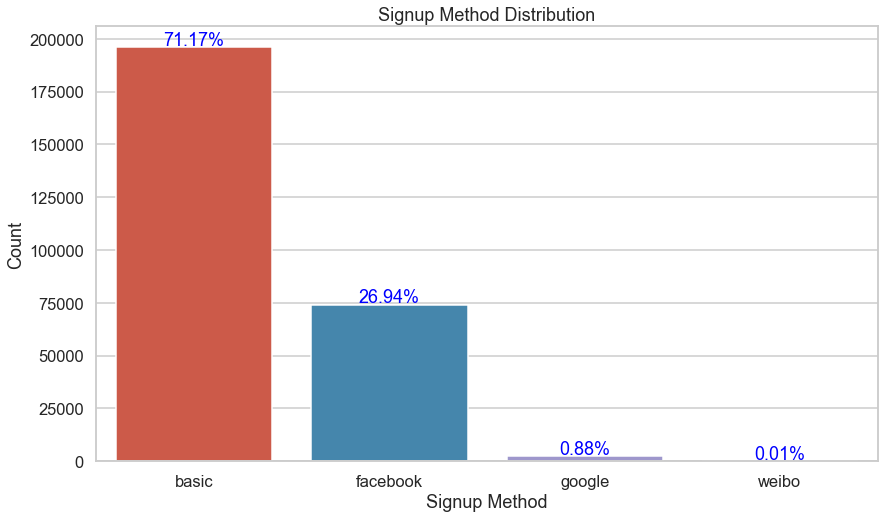

In [29]:
## Figure
plt.figure(figsize=(14, 8))
sign_order = df_total['signup_method'].value_counts()

sns.countplot(x='signup_method', data=df_total, order=sign_order.index)
plt.title('Signup Method Distribution')
plt.xlabel('Signup Method')
plt.ylabel('Count')


for i in range(sign_order.shape[0]):
    count = sign_order[i]
    strt='{:0.2f}%'.format(100*count / df_total.shape[0])
    plt.text(i, count+1000, strt, ha='center', color='blue')

> ### Comment: It seems that the majority of people about 71% sign up for the site using the basic Method and about 27% using Facebook.

-----

### `Let's examine "signup_flow" Feature`

In [30]:
## Examine the sign_flow Feature
df_total['signup_flow'].unique()

array([ 0.,  3.,  2., nan,  1., 24.,  8.,  6.,  5., 10., 25., 12.,  4.,
       16., 15., 20., 21., 23., 14.])

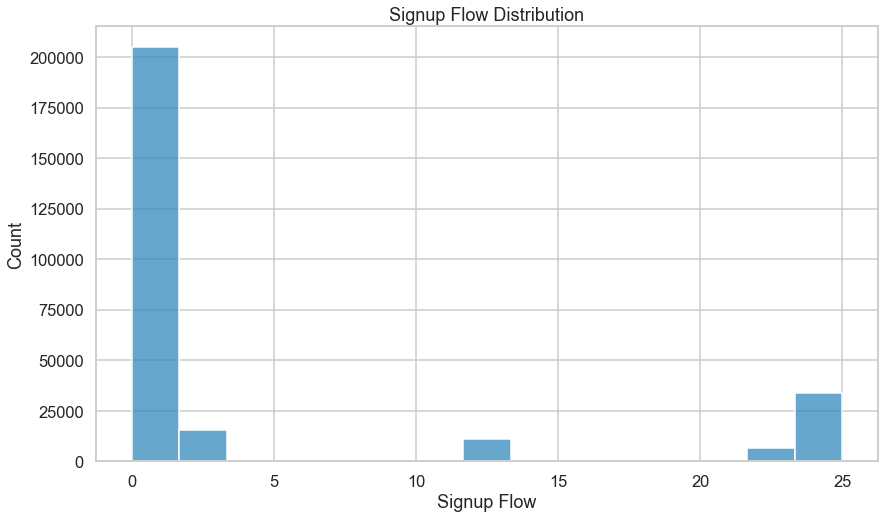

In [31]:
## Examine the sign_flow Feature

## Figure
plt.figure(figsize=(14, 8))

sns.histplot(x='signup_flow', data=df_total, bins=15)
plt.title('Signup Flow Distribution')
plt.xlabel('Signup Flow')
plt.ylabel('Count')
plt.show()

> ### Comment: It seems that the majority of people used page number 0, It means that people came directly to sign up.

-------

### `Let's examine "language" Feature`

In [32]:
## Examine (language) Feature
df_total['language'].unique()

array(['en', 'fr', nan, 'de', 'es', 'it', 'zh', 'ko', 'ja', 'ru', 'pl',
       'el', 'sv', 'pt', 'nl', 'hu', 'da', 'id', 'fi', 'no', 'tr', 'th',
       'cs', 'hr', 'ca', 'is', '-unknown-'], dtype=object)

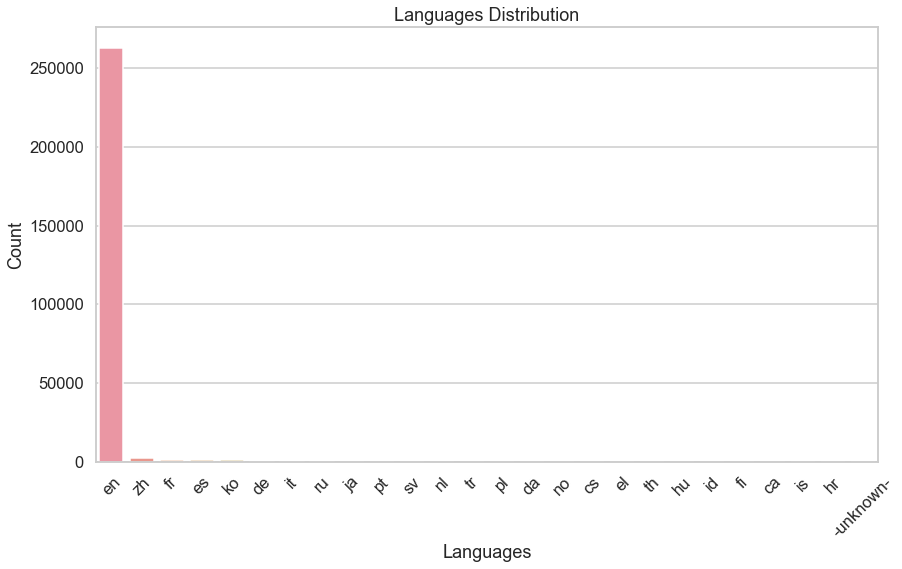

In [33]:
## Figure
plt.figure(figsize=(14, 8))
lang_order = df_total['language'].value_counts()

sns.countplot(x='language', data=df_total, order=lang_order.index)
plt.title('Languages Distribution')
plt.xlabel('Languages')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

> ### Comment: It seems that the majority language used was English, It makes sense because this data is for US citizens.

--------

### `Let's examine "affiliate_channel" Feature`

In [34]:
## Examine (affiliate_channel) Feature
df_total['affiliate_channel'].unique()

array(['direct', 'seo', 'other', 'sem-non-brand', 'content', nan,
       'sem-brand', 'remarketing', 'api'], dtype=object)

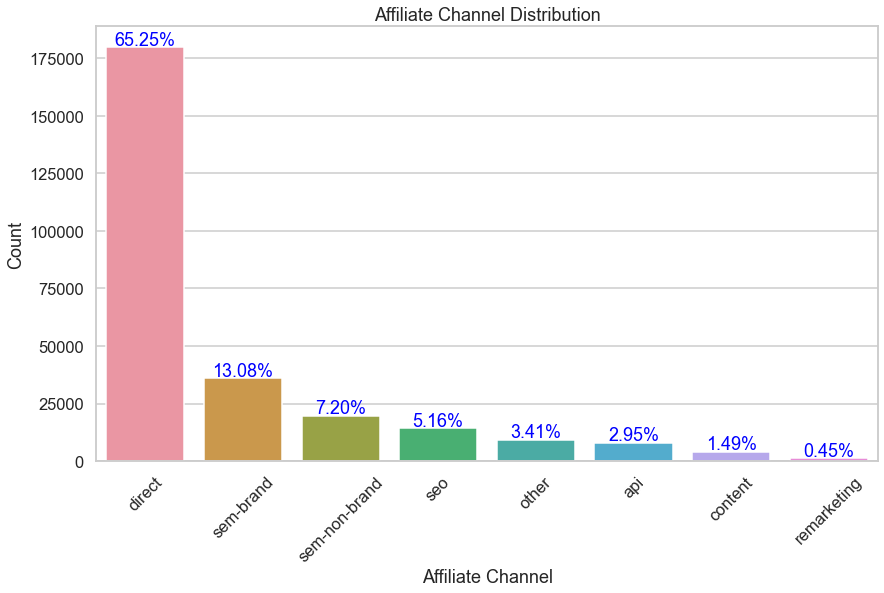

In [35]:
## Figure
plt.figure(figsize=(14, 8))
chann_order = df_total['affiliate_channel'].value_counts()

sns.countplot(x='affiliate_channel', data=df_total, order=chann_order.index)
plt.title('Affiliate Channel Distribution')
plt.xlabel('Affiliate Channel')
plt.ylabel('Count')
plt.xticks(rotation=45)


for i in range(chann_order.shape[0]):
    count = chann_order[i]
    strt='{:0.2f}%'.format(100*count / df_total.shape[0])
    plt.text(i, count+1000, strt, ha='center', color='blue')

* `SEO -- Search Engine Optimization`
* `SEM -- Search Engine Marketing`

> ### Comment: It seems that the majority of paid marketing technique used was using direct marketing
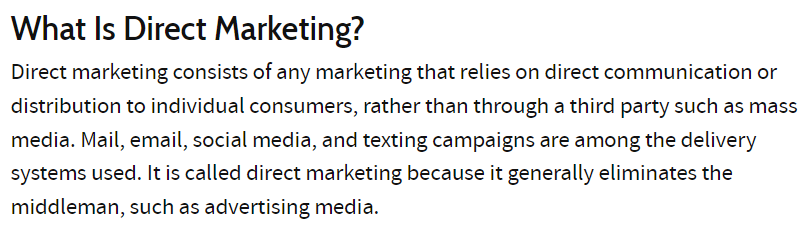

----

### `Let's examine "affiliate_provider" Feature`

In [36]:
## Examine (affiliate_provider) Feature
df_total['affiliate_provider'].unique()

array(['direct', 'google', 'other', 'craigslist', 'facebook', nan, 'vast',
       'bing', 'meetup', 'facebook-open-graph', 'email-marketing',
       'yahoo', 'padmapper', 'gsp', 'wayn', 'naver', 'baidu', 'yandex',
       'daum'], dtype=object)

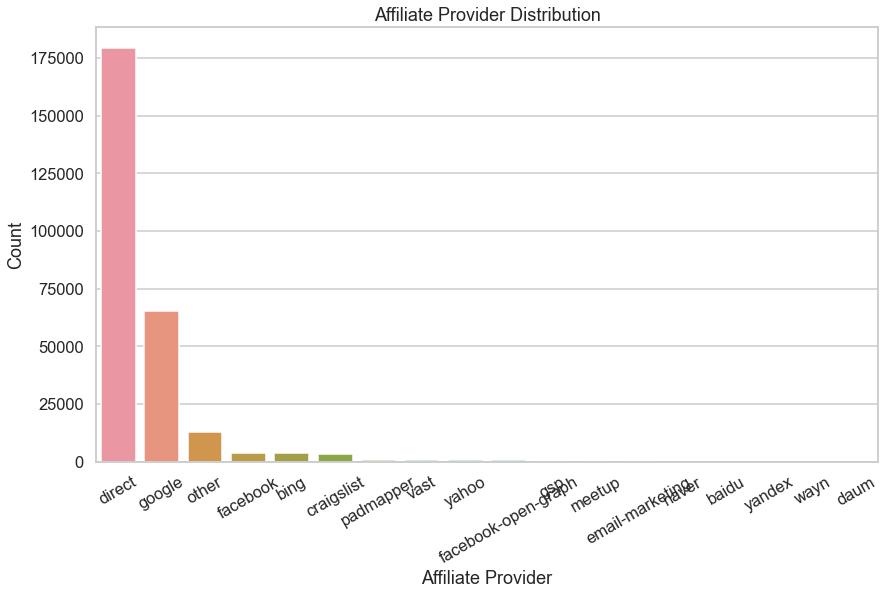

In [37]:
## Figure
plt.figure(figsize=(14, 8))
prov_order = df_total['affiliate_provider'].value_counts()

sns.countplot(x='affiliate_provider', data=df_total, order=prov_order.index)
plt.title('Affiliate Provider Distribution')
plt.xlabel('Affiliate Provider')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

> ### Comment: It seems that the majority provider for paid marketing was (google) after using no provider for paid marketing which is a (direct) method which is at (affiliate_chnnel) also direct which means local channel and local provider.

----

### `Let's examine "first_affiliate_tracked" Feature`

`whats the first marketing the user interacted with before the signing up`

In [38]:
## Examine (first_affiliate_tracked) Feature
df_total['first_affiliate_tracked'].unique()

array(['untracked', 'omg', nan, 'linked', 'tracked-other', 'product',
       'marketing', 'local ops'], dtype=object)

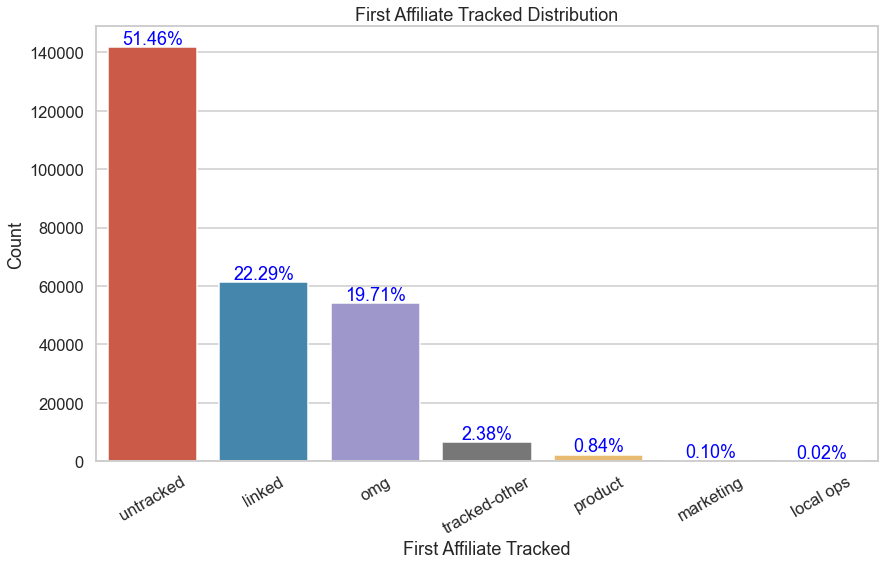

In [39]:
## Figure
plt.figure(figsize=(14, 8))
tracked_order = df_total['first_affiliate_tracked'].value_counts()

sns.countplot(x='first_affiliate_tracked', data=df_total, order=tracked_order.index)
plt.title('First Affiliate Tracked Distribution')
plt.xlabel('First Affiliate Tracked')
plt.ylabel('Count')
plt.xticks(rotation=30)


for i in range(tracked_order.shape[0]):
    count = tracked_order[i]
    strt='{:0.2f}%'.format(100*count / df_total.shape[0])
    plt.text(i, count+1000, strt, ha='center', color='blue')

> ### Comment: It seems that the first marketing the user interact with before signing up was linked and omg, but about (51%) was untracked. 

* `omg --> online marketing gurus`

-----

### `Let's examine "signup_app" Feature`

In [40]:
## Examine (signup_app) Feature
df_total['signup_app'].unique()

array(['Web', nan, 'Moweb', 'iOS', 'Android'], dtype=object)

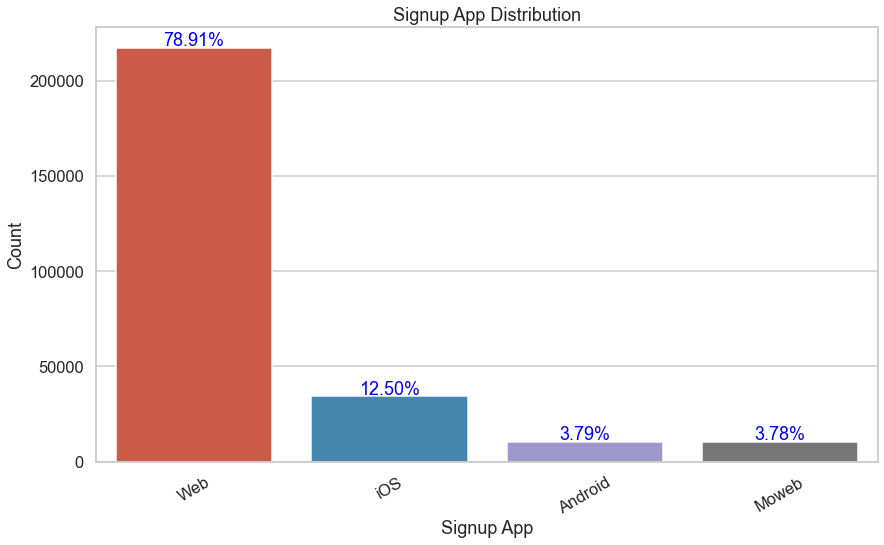

In [41]:
## Figure
plt.figure(figsize=(14, 8))
signapp_order = df_total['signup_app'].value_counts()

sns.countplot(x='signup_app', data=df_total, order=signapp_order.index)
plt.title('Signup App Distribution')
plt.xlabel('Signup App')
plt.ylabel('Count')
plt.xticks(rotation=30)


for i in range(signapp_order.shape[0]):
    count = signapp_order[i]
    strt='{:0.2f}%'.format(100*count / df_total.shape[0])
    plt.text(i, count+1000, strt, ha='center', color='blue')

> ### Comment: It seems that the majority of signup app used was web by about 79%

------

### `Let's examine "first_device_type" Feature`

In [42]:
## Examine (first_device_type) Feature
df_total['first_device_type'].unique()

array(['Mac Desktop', 'Windows Desktop', 'iPhone', 'Other/Unknown',
       'Desktop (Other)', 'Android Tablet', 'iPad', 'Android Phone', nan,
       'SmartPhone (Other)'], dtype=object)

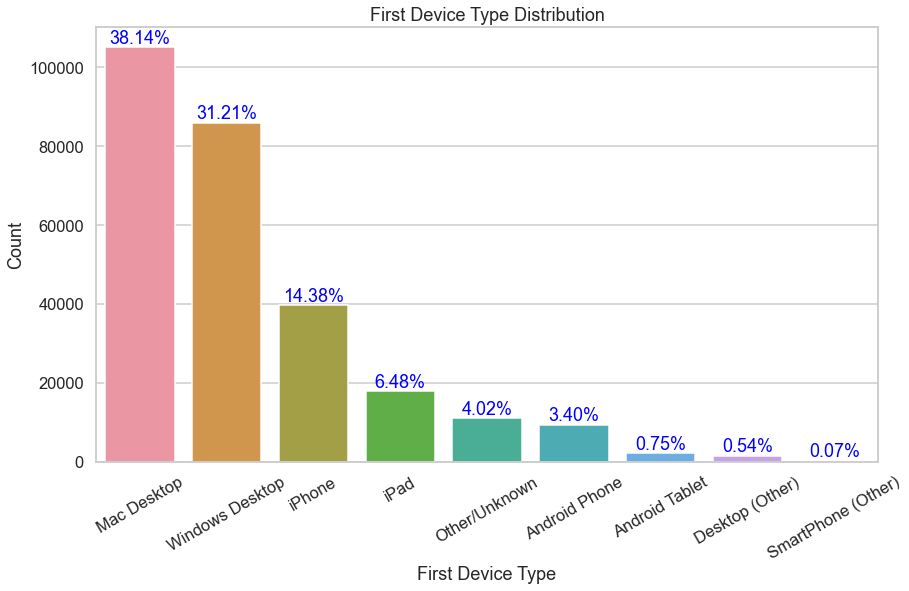

In [43]:
## Figure
plt.figure(figsize=(14, 8))
device_order = df_total['first_device_type'].value_counts()

sns.countplot(x='first_device_type', data=df_total, order=device_order.index)
plt.title('First Device Type Distribution')
plt.xlabel('First Device Type')
plt.ylabel('Count')
plt.xticks(rotation=30)


for i in range(device_order.shape[0]):
    count = device_order[i]
    strt='{:0.2f}%'.format(100*count / df_total.shape[0])
    plt.text(i, count+1000, strt, ha='center', color='blue')

> ### Comment: It seems that the majority of Devices used were (Mac Desktop  and Windows Desktop)

--------

## `Bivariate Visualization`

### `Gender Distribution with different Destinations`

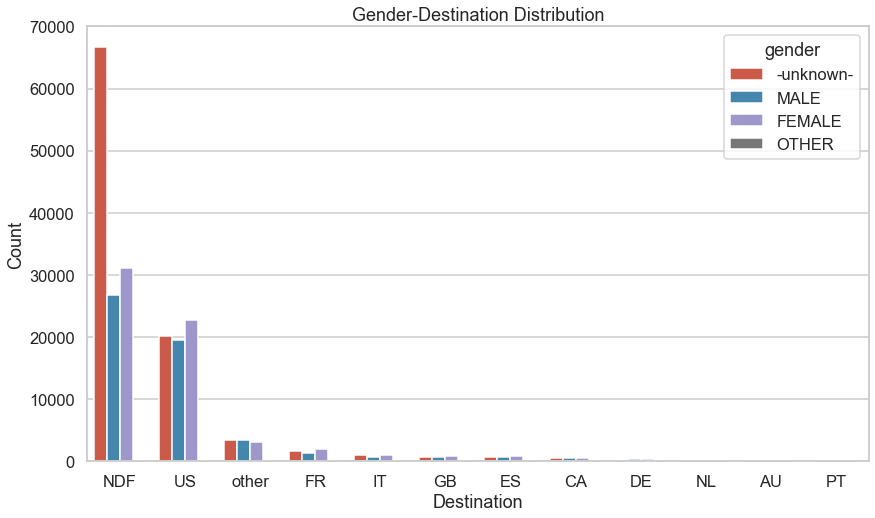

In [44]:
## Gender-Destination Distribution Plot
plt.figure(figsize=(14, 8))

destn_order = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order=destn_order, hue='gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Gender-Destination Distribution')
plt.show()

> ### Comment: It seems that the majority of people have (NDF) and they don't register their Gender, but for those who book a ticket the most popular Destination is (US) as we say that before and almost all types of Gender (Female, Male, Unknown) are equally, and (Other, Gender) is very small and doesn't appear in the graph compared to other results.

---------

### `What about getting Histogram distribution for Age of each gender alone`

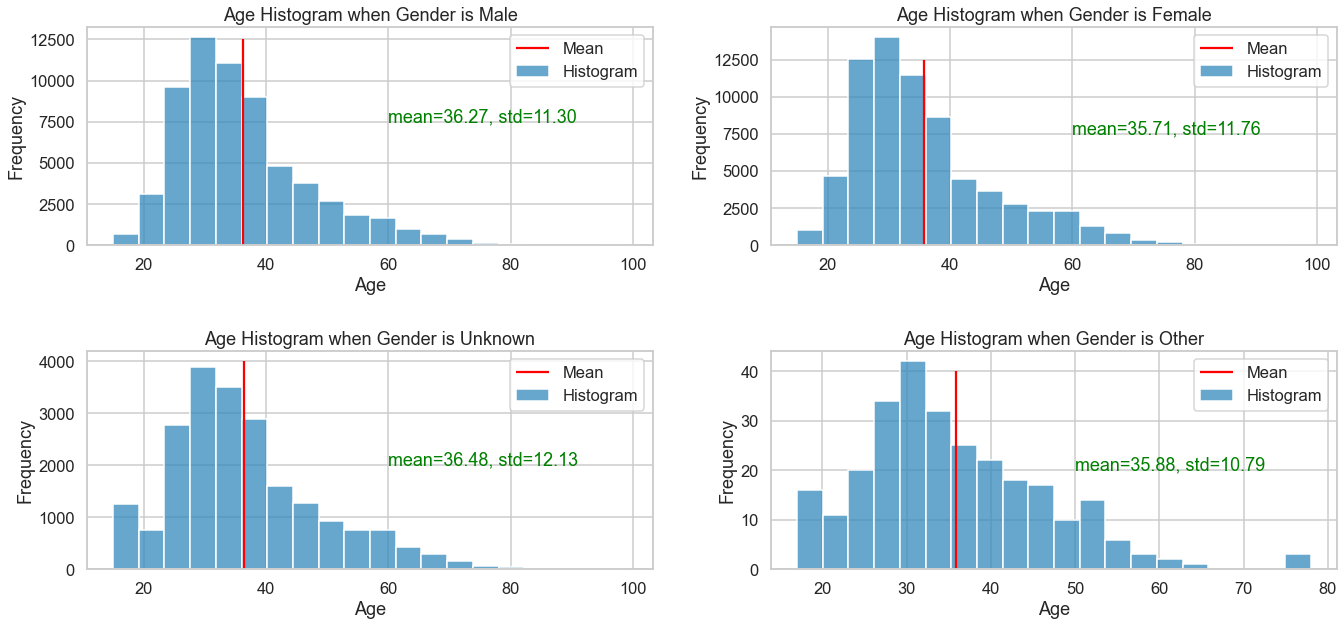

In [45]:
## What about getting Histogram distribution for Age of each gender alone

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.tight_layout(pad=4)  ## to avoid overlaping of titles in subplots (try comment it you will know)

## Male
plt.sca(ax[0, 0])
sns.histplot(df_total[df_total['gender']=='MALE']['age'], bins=20, label='Histogram')
plt.title(f'Female Gender Distribution')
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Age Histogram when Gender is Male')
std_male, mean_male = sorted(df_total[df_total['gender']=='MALE']['age'].agg({'mean', 'std'}).values)
plt.text(s=f'mean={mean_male:.2f}, std={std_male:.2f}', x=60, y=7500, color='green')
plt.vlines(x=mean_male, ymin=0, ymax=12500, color='red', label='Mean')
plt.legend()

## FEMALE
plt.sca(ax[0, 1])
sns.histplot(df_total[df_total['gender']=='FEMALE']['age'], bins=20, label='Histogram')
plt.title('Age Histogram when Gender is Female')
std_female, mean_female = sorted(df_total[df_total['gender']=='FEMALE']['age'].agg({'mean', 'std'}).values)
plt.text(s=f'mean={mean_female:.2f}, std={std_female:.2f}', x=60, y=7500, color='green')
plt.vlines(x=mean_female, ymin=0, ymax=12500, color='red', label='Mean')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Age')

## unknown
plt.sca(ax[1, 0])
sns.histplot(df_total[df_total['gender']=='-unknown-']['age'], bins=20, label='Histogram')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Histogram when Gender is Unknown')
std_unknown, mean_unknown = sorted(df_total[df_total['gender']=='-unknown-']['age'].agg({'mean', 'std'}).values)
plt.text(s=f'mean={mean_unknown:.2f}, std={std_unknown:.2f}', x=60, y=2000, color='green')
plt.vlines(x=mean_unknown, ymin=0, ymax=4000, color='red', label='Mean')
plt.legend()

## OTHER
plt.sca(ax[1, 1])
sns.histplot(df_total[df_total['gender']=='OTHER']['age'], bins=20, label='Histogram')
plt.title('Age Histogram when Gender is Other')
plt.xlabel('Age')
std_other, mean_other = sorted(df_total[df_total['gender']=='OTHER']['age'].agg({'mean', 'std'}).values)
plt.text(s=f'mean={mean_other:.2f}, std={std_other:.2f}', x=50, y=20, color='green')
plt.vlines(x=mean_other, ymin=0, ymax=40, color='red', label='Mean')
plt.ylabel('Frequency')
plt.xlabel('Age')

plt.legend()
plt.show()

> ### Comment: It seems that although (-unknown-) gender is the most frequent gender in the Dataset as we did that before, it appears here that it is less than (gender -Male & Female-), that happened because we get statistics values on Age Feature and in most value of -unknown- gender, Age is a null value, It seems that a lot of people visit the site or create an account without registering their age or their gender, It also appears that (Other) gender is too small compared to (Male & Female) which are almost typical in mean, std, and Histogram.

--------

### `What about Destination with Age - Boxplot`

In [46]:
## getting quartiles for age according to each country_destination
quartiles_age = pd.DataFrame(df_train.groupby('country_destination')['age'].quantile([0.25, 0.5, 0.75]))
quartiles_age          ## They are almost typical in (Q1, Q2-Median-, Q3), No big deal in Numbers as I think

age
country_destination            
AU                  0.25  29.00
                    0.50  35.00
                    0.75  44.00
CA                  0.25  29.00
                    0.50  34.00
                    0.75  43.00
DE                  0.25  28.00
                    0.50  34.00
                    0.75  43.00
ES                  0.25  27.00
                    0.50  32.00
                    0.75  40.00
FR                  0.25  29.00
                    0.50  34.00
                    0.75  44.00
GB                  0.25  29.00
                    0.50  35.00
                    0.75  46.00
IT                  0.25  28.00
                    0.50  34.00
                    0.75  44.00
NDF                 0.25  28.00
                    0.50  34.00
                    0.75  44.00
NL                  0.25  28.00
                    0.50  33.00
                    0.75  41.00
PT                  0.25  28.00
                    0.50  32.00
                    0.75  41.75
US                  0.25  28.00
                    0.50  33.00
                    0.75  41.00
other               0.25  29.00
                    0.50  34.00
                    0.75  42.00

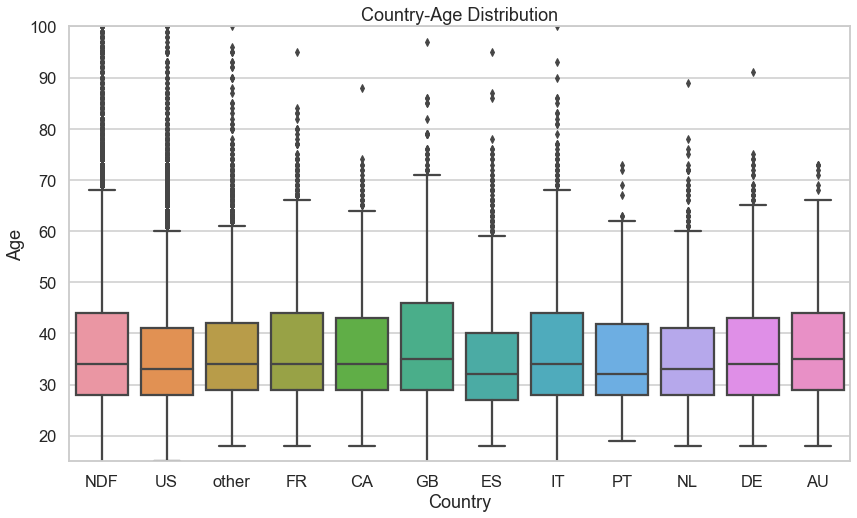

In [47]:
## Destination-Age distribution plot
plt.figure(figsize=(14, 8))

sns.boxplot(data=df_train, y='age', x='country_destination')
plt.xlabel('Country')
plt.ylabel('Age')
plt.title('Country-Age Distribution')
plt.ylim(15, 100)  ## the range we decided to work on and make aother value greater or less to be nan
plt.show()

> ### Comment: It seems that no difference between all Destinations in (Q1, Q2-Median-, Q3), They are almost typical, but the difference between them is the max and min value of the extreme ages for all Destinations, For example for (US & IT & FR) I think there are extreme values for age to be more than (1.5*IQR+Q3) because the Life Expectancy of these countries is high as I think.  <br />
I get these values from this [Site](https://www.worldometers.info/demographics/life-expectancy/)

------

## `Age & Gender Distribution for booking for both 2013 & 2014`

`2013 & 2014 are the last two years and more people booked at these years rather than before`

## `2013`

### `Age Distribution of booking in different months of 2013`

In [48]:
## Age wise distribution of the booking in different months of 2013
## select only 2013
df_month_age_13 = df_total[df_total['date_account_created'].dt.year==2013]
## in the right format
df_month_age_13['month_2013'] = df_month_age_13['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df_month_age_13 = df_month_age_13.groupby(['month_2013', 'age_bins']).count() 
df_month_age_13 = df_month_age_13.reset_index()
df_month_age_13.head()

,month_2013,age_bins,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,week_day,acc_year
0,01-2013,15-20,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
1,01-2013,20-30,827,827,827,827,827,827,827,827,827,827,827,827,827,827,827
2,01-2013,30-40,1095,1095,1095,1095,1095,1095,1095,1095,1095,1095,1095,1095,1095,1095,1095
3,01-2013,40-50,474,474,474,474,474,474,474,474,474,474,474,474,474,474,474
4,01-2013,50-60,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232


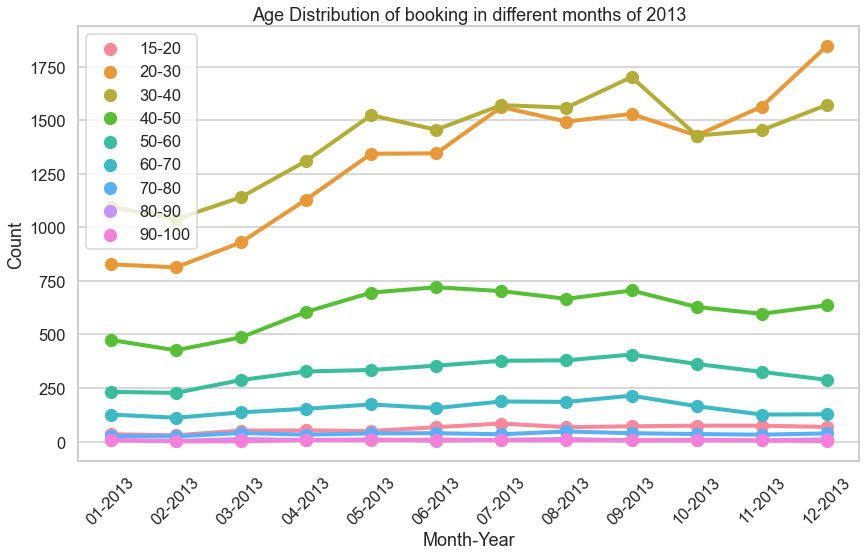

In [49]:
## Age Distribution of the booking in different months of 2013
plt.figure(figsize=(14, 8))

sns.pointplot(data=df_month_age_13, x='month_2013', y='affiliate_provider', hue='age_bins')
plt.title('Age Distribution of booking in different months of 2013')
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

> ### Comment: It seems that people with age in range(20-40) are much more active than people in different age ranges, and with time it is growing, and it is almost stable and small for ages in ranges above 50 and less than 20, It also seems that the most popular months are (September and December), for September I think because people tend to travel or book a ticket in summer season rather than other seasons, and December, I think maybe that people tend to do that in mid-year vacation as I think.

-------

### `Gender Distribution of booking in different months of 2013`

In [50]:
## Gender wise distribution of the booking in different months of 2013
## select only 2013
df_month_gender_13 = df_total[df_total['date_account_created'].dt.year==2013]
## in the right format
df_month_gender_13['month_2013'] = df_month_gender_13['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df_month_gender_13 = df_month_gender_13.groupby(['month_2013', 'gender']).count()
df_month_gender_13 = df_month_gender_13.reset_index()
df_month_gender_13.head()

,month_2013,gender,date_account_created,timestamp_first_active,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age_bins,week_day,acc_year
0,01-2013,-unknown-,1607,1607,244,1607,1607,1607,1607,1607,1597,1607,1607,1607,244,1607,1607
1,01-2013,FEMALE,1498,1498,1393,1498,1498,1498,1498,1498,1497,1498,1498,1498,1393,1498,1498
2,01-2013,MALE,1250,1250,1183,1250,1250,1250,1250,1250,1248,1250,1250,1250,1183,1250,1250
3,01-2013,OTHER,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
4,02-2013,-unknown-,1725,1725,265,1725,1725,1725,1725,1725,1715,1725,1725,1725,265,1725,1725


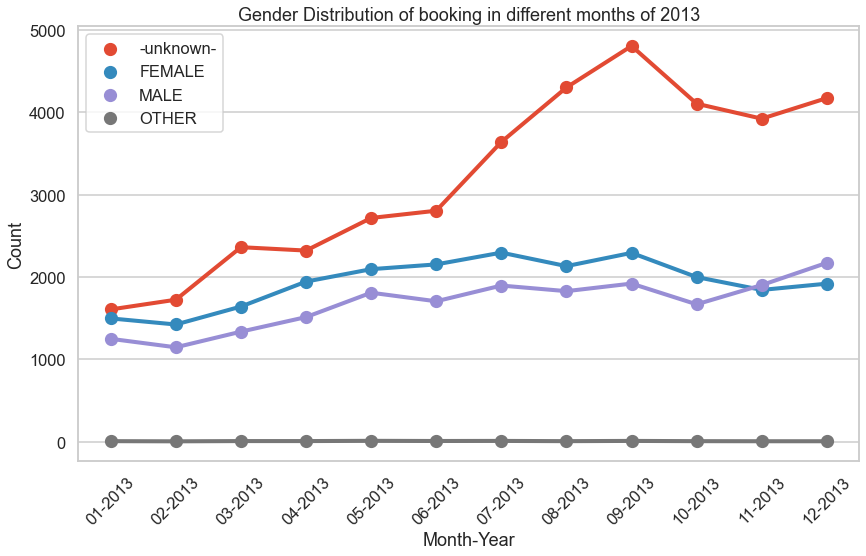

In [51]:
## Gender wise distribution of the booking in different months of 2013
plt.figure(figsize=(14, 8))

sns.pointplot(data=df_month_gender_13, x='month_2013', y='affiliate_provider', hue='gender')
plt.title('Gender Distribution of booking in different months of 2013')
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

> ### Comment: It seems that the most active month in 2013 for different gender categories is (September), In my opinion the reason for that people tends to book a ticket and travel in the summer season as it is much better than any other season
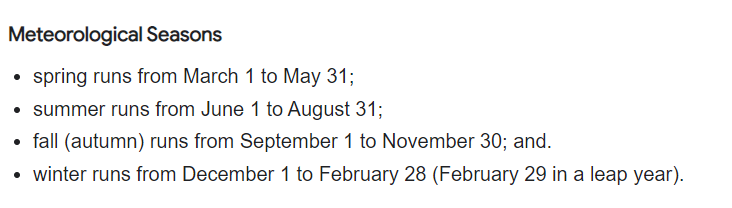

------

## `2014`

### `Age Distribution of booking in different months of 2014`

In [52]:
## Age wise distribution of the booking in different months of 2013
## select only 2014
df_month_age_14 = df_total[df_total['date_account_created'].dt.year==2014]
## in the right format
df_month_age_14['month_2014'] = df_month_age_14['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df_month_age_14 = df_month_age_14.groupby(['month_2014', 'age_bins']).count() 
df_month_age_14 = df_month_age_14.reset_index()
df_month_age_14.head()

,month_2014,age_bins,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,week_day,acc_year
0,01-2014,15-20,120,120,120,120,120,120,120,120,120,117,120,120,120,120,120
1,01-2014,20-30,2399,2399,2399,2399,2399,2399,2399,2399,2399,2370,2399,2399,2399,2399,2399
2,01-2014,30-40,1940,1940,1940,1940,1940,1940,1940,1940,1940,1926,1940,1940,1940,1940,1940
3,01-2014,40-50,759,759,759,759,759,759,759,759,759,755,759,759,759,759,759
4,01-2014,50-60,428,428,428,428,428,428,428,428,428,425,428,428,428,428,428


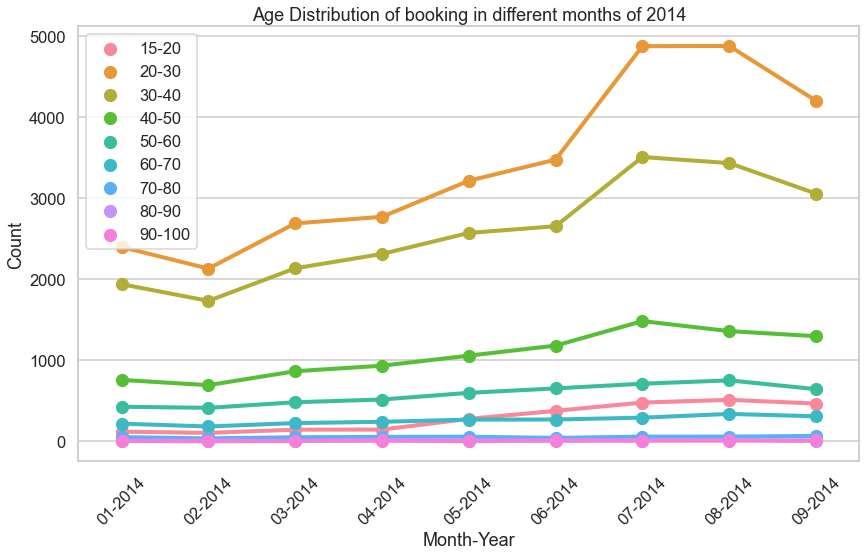

In [53]:
## Age Distribution of the booking in different months of 2014
plt.figure(figsize=(14, 8))

sns.pointplot(data=df_month_age_14, x='month_2014', y='affiliate_provider', hue='age_bins')
plt.title('Age Distribution of booking in different months of 2014')
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

> ### Comment: It seems that the same comments I wrote for (2013) before, but here months (July, September, August), I think people tend to book a ticket and travel in these months in summer, and also I think because it is a Vacation time 

------

### `Gender Distribution of booking in different months of 2014`

In [54]:
## Gender wise distribution of the booking in different months of 2014
## select only 2014
df_month_gender_14 = df_total[df_total['date_account_created'].dt.year==2014]
## in the right format
df_month_gender_14['month_2014'] = df_month_gender_14['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df_month_gender_14 = df_month_gender_14.groupby(['month_2014', 'gender']).count()
df_month_gender_14 = df_month_gender_14.reset_index()
df_month_gender_14.head()

,month_2014,gender,date_account_created,timestamp_first_active,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age_bins,week_day,acc_year
0,01-2014,-unknown-,5698,5698,884,5698,5698,5698,5698,5698,5465,5698,5698,5698,884,5698,5698
1,01-2014,FEMALE,2863,2863,2722,2863,2863,2863,2863,2863,2839,2863,2863,2863,2722,2863,2863
2,01-2014,MALE,2417,2417,2314,2417,2417,2417,2417,2417,2386,2417,2417,2417,2313,2417,2417
3,01-2014,OTHER,14,14,11,14,14,14,14,14,14,14,14,14,11,14,14
4,02-2014,-unknown-,5159,5159,858,5159,5159,5159,5159,5159,4965,5159,5159,5159,858,5159,5159


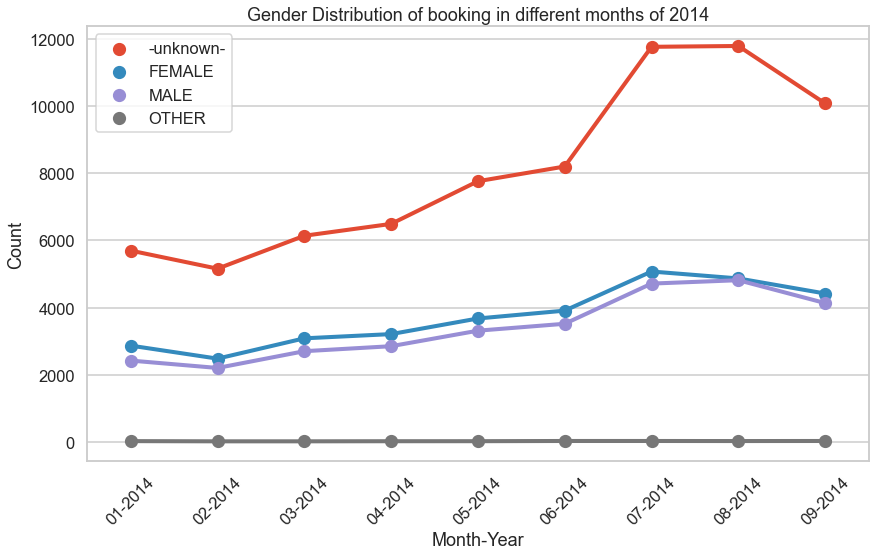

In [55]:
## Gender wise distribution of the booking in different months of 2014
plt.figure(figsize=(14, 8))

sns.pointplot(data=df_month_gender_14, x='month_2014', y='affiliate_provider', hue='gender')
plt.title('Gender Distribution of booking in different months of 2014')
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

> ### Comment: The same above comment 

---------

### `Gender Distribution for each Country`

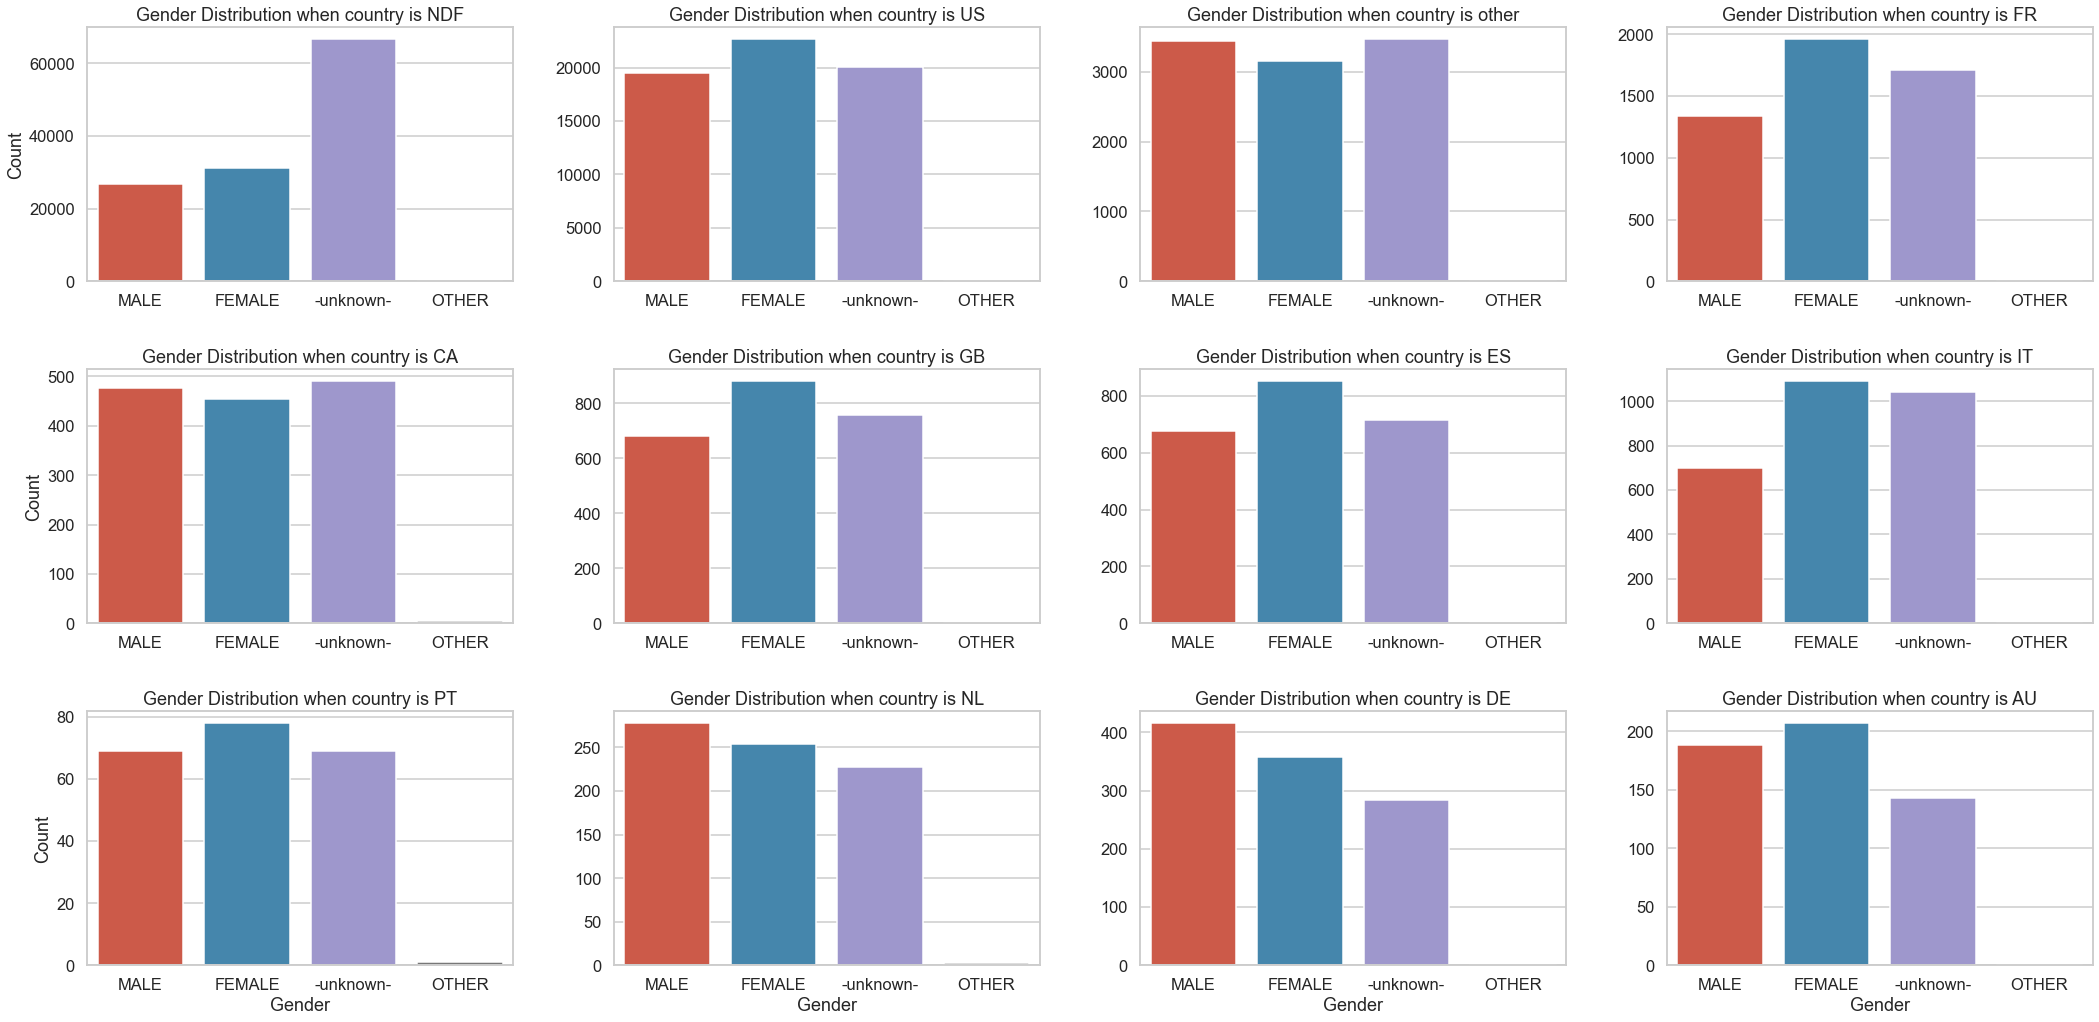

In [56]:
## unique
dstn_uniq = pd.unique(df_train['country_destination']).reshape(3, 4)

## figure

fig, ax = plt.subplots(3, 4, figsize=(30, 15))
fig.tight_layout(pad=3)  

for i in range(3):
    for j in range(4):
        plt.sca(ax[i, j])
        to_plot_each = df_train[df_train['country_destination']==dstn_uniq[i, j]]['gender']

        sns.countplot(to_plot_each, order=[ 'MALE', 'FEMALE', '-unknown-', 'OTHER'])
        plt.title(f'Gender Distribution when country is {dstn_uniq[i, j]}')
    
        if i==2:
            plt.xlabel('Gender')
        else:
            plt.xlabel('')
        if j==0:
            plt.ylabel('Count')
        else:
            plt.ylabel('')

> ### Comment: It seems gender distribution varies according to different countries

------

### `signup_method Distribution for each Country`

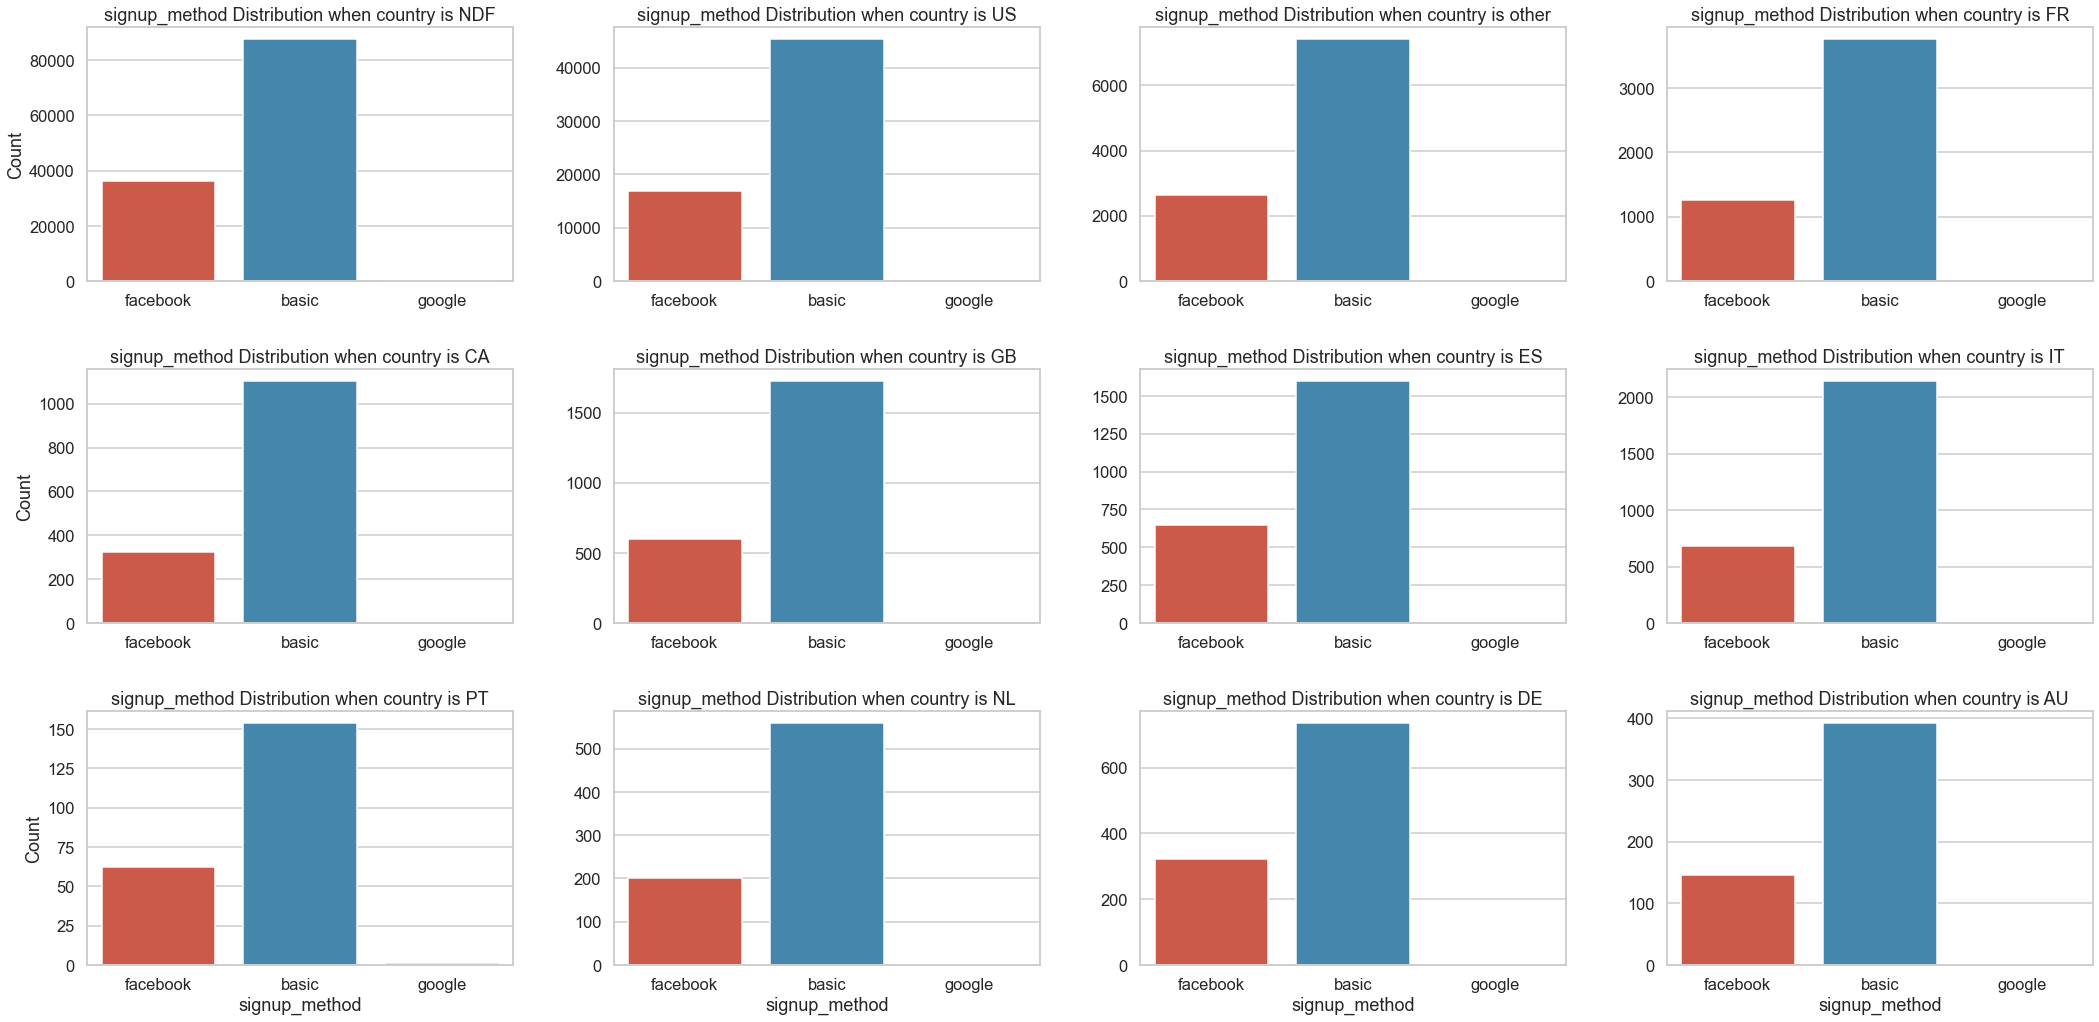

In [57]:
## figure
fig, ax = plt.subplots(3, 4, figsize=(30, 15))
fig.tight_layout(pad=3)  

for i in range(3):
    for j in range(4):
        plt.sca(ax[i, j])
        to_plot_each = df_train[df_train['country_destination']==dstn_uniq[i, j]]['signup_method']

        sns.countplot(to_plot_each, order=['facebook', 'basic', 'google'])
        plt.title(f'signup_method Distribution when country is {dstn_uniq[i, j]}')
    
        if i==2:
            plt.xlabel('signup_method')
        else:
            plt.xlabel('')
        if j==0:
            plt.ylabel('Count')
        else:
            plt.ylabel('')

> ### Comment: It seems that no big difference, I think it isn't an important Feature

------

### `language Distribution for each Country`

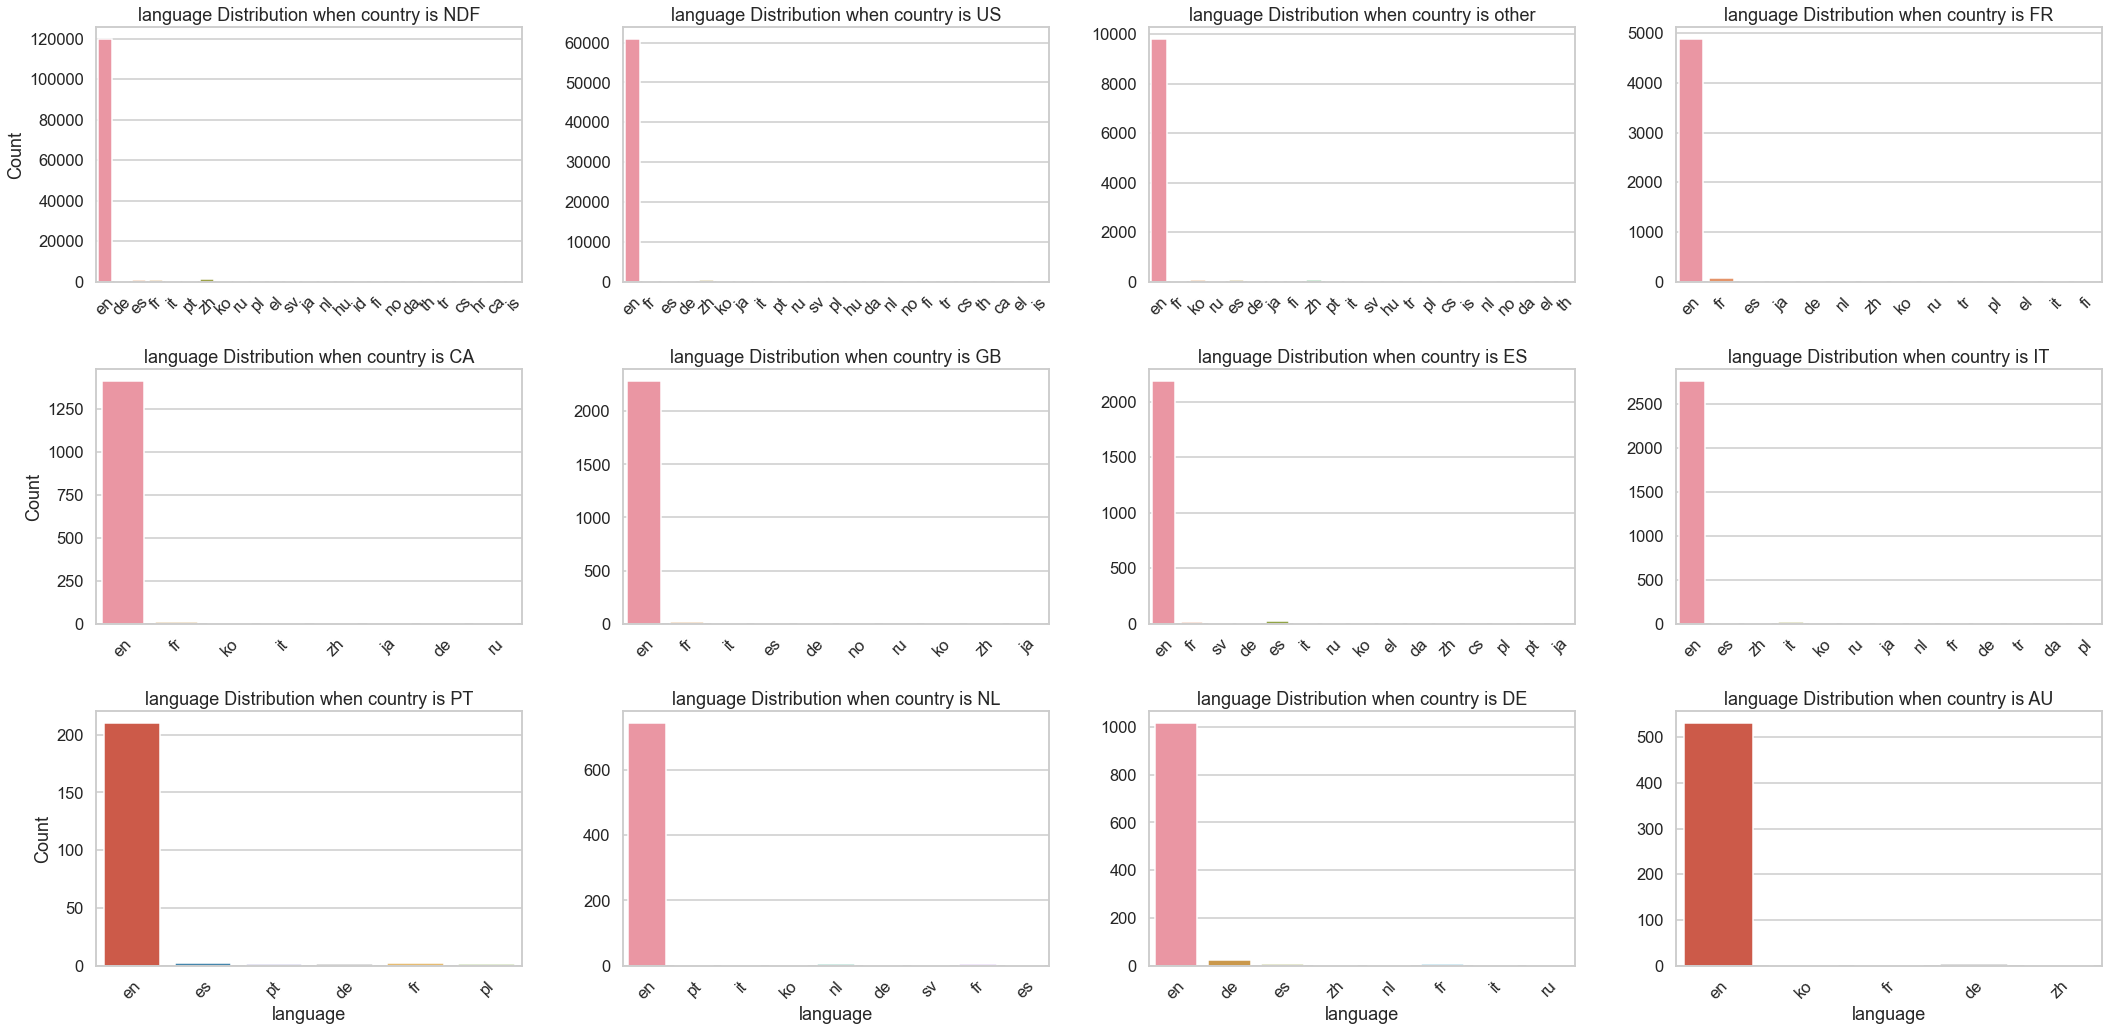

In [58]:
## figure
fig, ax = plt.subplots(3, 4, figsize=(30, 15))
fig.tight_layout(pad=3)  

for i in range(3):
    for j in range(4):
        plt.sca(ax[i, j])
        to_plot_each = df_train[df_train['country_destination']==dstn_uniq[i, j]]['language']

        sns.countplot(to_plot_each)
        plt.title(f'language Distribution when country is {dstn_uniq[i, j]}')
        plt.xticks(rotation=45)
        if i==2:
            plt.xlabel('language')
        else:
            plt.xlabel('')
        if j==0:
            plt.ylabel('Count')
        else:
            plt.ylabel('')

> ### Comment: It seems that language is very big compared to any other language, I think it isn't an important Feature

--------------

### `affiliate_channel Distribution for each Country`

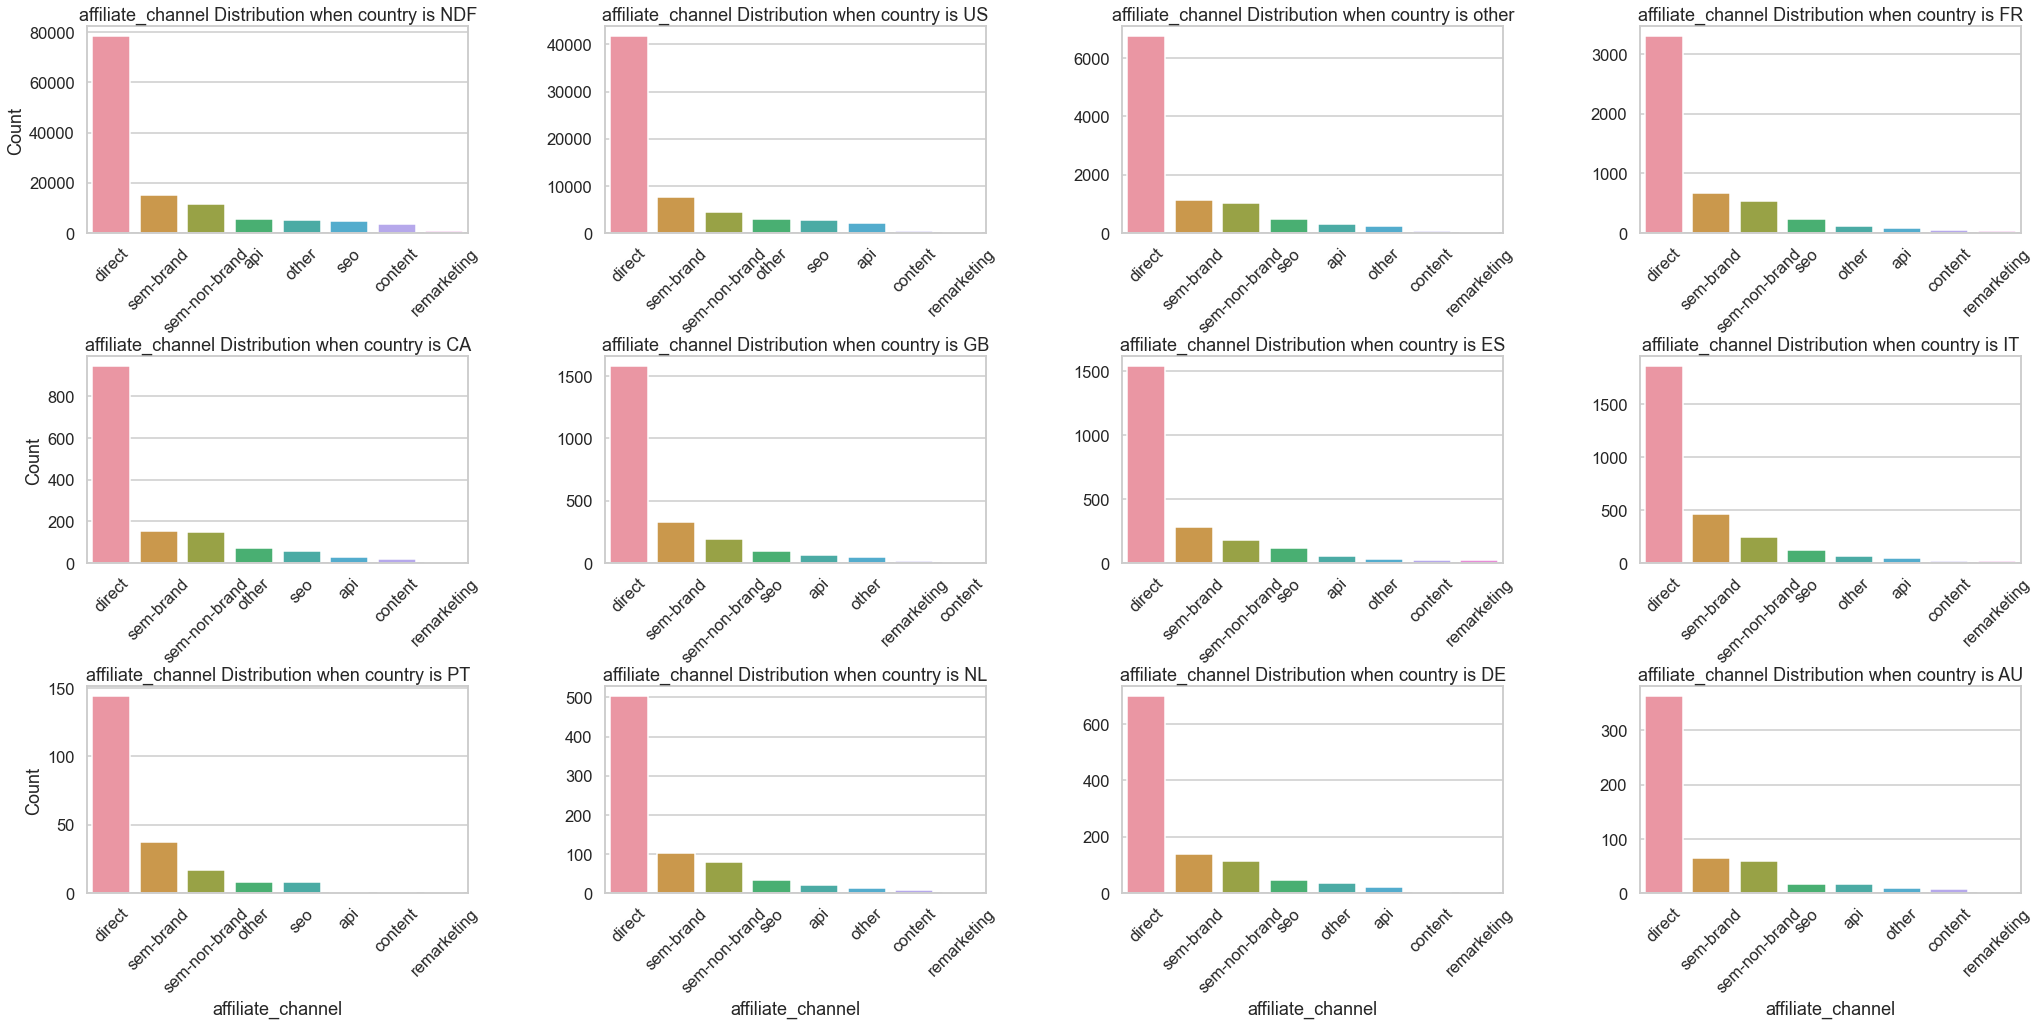

In [59]:
## figure
fig, ax = plt.subplots(3, 4, figsize=(30, 15))
fig.tight_layout(pad=5)  

for i in range(3):
    for j in range(4):
        plt.sca(ax[i, j])
        to_plot_each = df_train[df_train['country_destination']==dstn_uniq[i, j]]['affiliate_channel']

        sns.countplot(to_plot_each, order=to_plot_each.value_counts().index)
        plt.title(f'affiliate_channel Distribution when country is {dstn_uniq[i, j]}')
        plt.xticks(rotation=45)
        if i==2:
            plt.xlabel('affiliate_channel')
        else:
            plt.xlabel('')
        if j==0:
            plt.ylabel('Count')
        else:
            plt.ylabel('')

> ### Comment: It seems that no big difference, I will wait to get the importance features using model

------------

### `affiliate_provider Distribution for each Country`

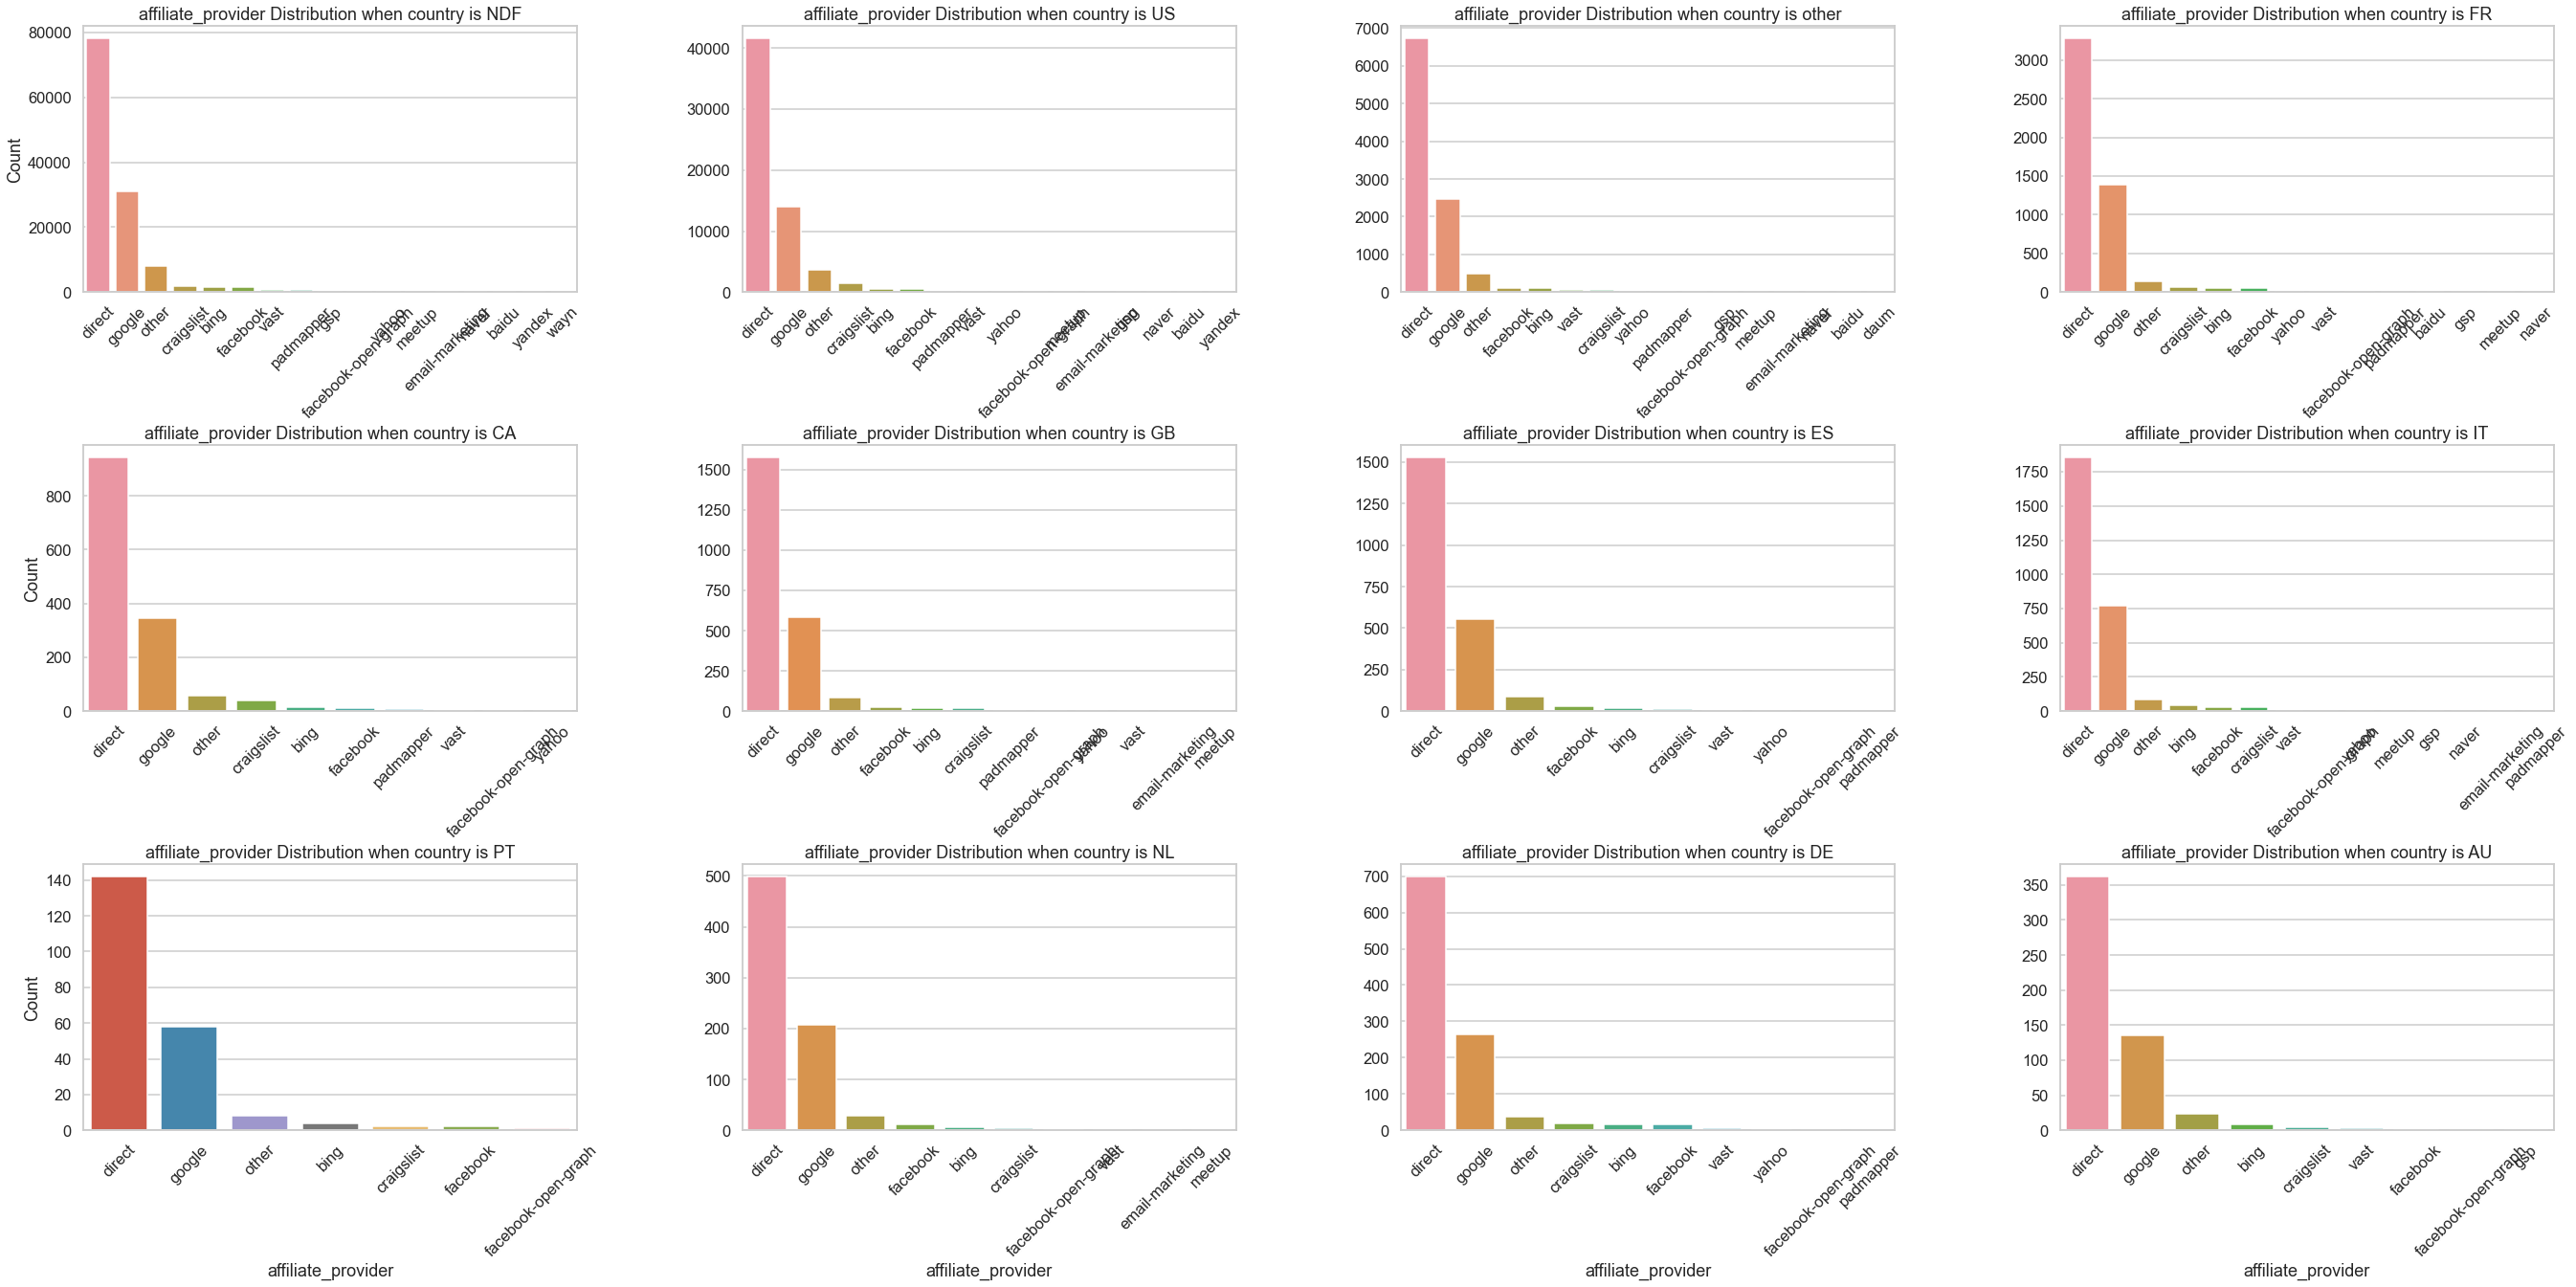

In [60]:
## figure
fig, ax = plt.subplots(3, 4, figsize=(40, 20))
fig.tight_layout(pad=7)  

for i in range(3):
    for j in range(4):
        plt.sca(ax[i, j])
        to_plot_each = df_train[df_train['country_destination']==dstn_uniq[i, j]]['affiliate_provider']

        sns.countplot(to_plot_each, order=to_plot_each.value_counts().index)
        plt.title(f'affiliate_provider Distribution when country is {dstn_uniq[i, j]}')
        plt.xticks(rotation=45)
        if i==2:
            plt.xlabel('affiliate_provider')
        else:
            plt.xlabel('')
        if j==0:
            plt.ylabel('Count')
        else:
            plt.ylabel('')

> ### Comment: It seems that no big difference, I will wait to get the importance features using model

-----

### `signup_app Distribution for each Country`

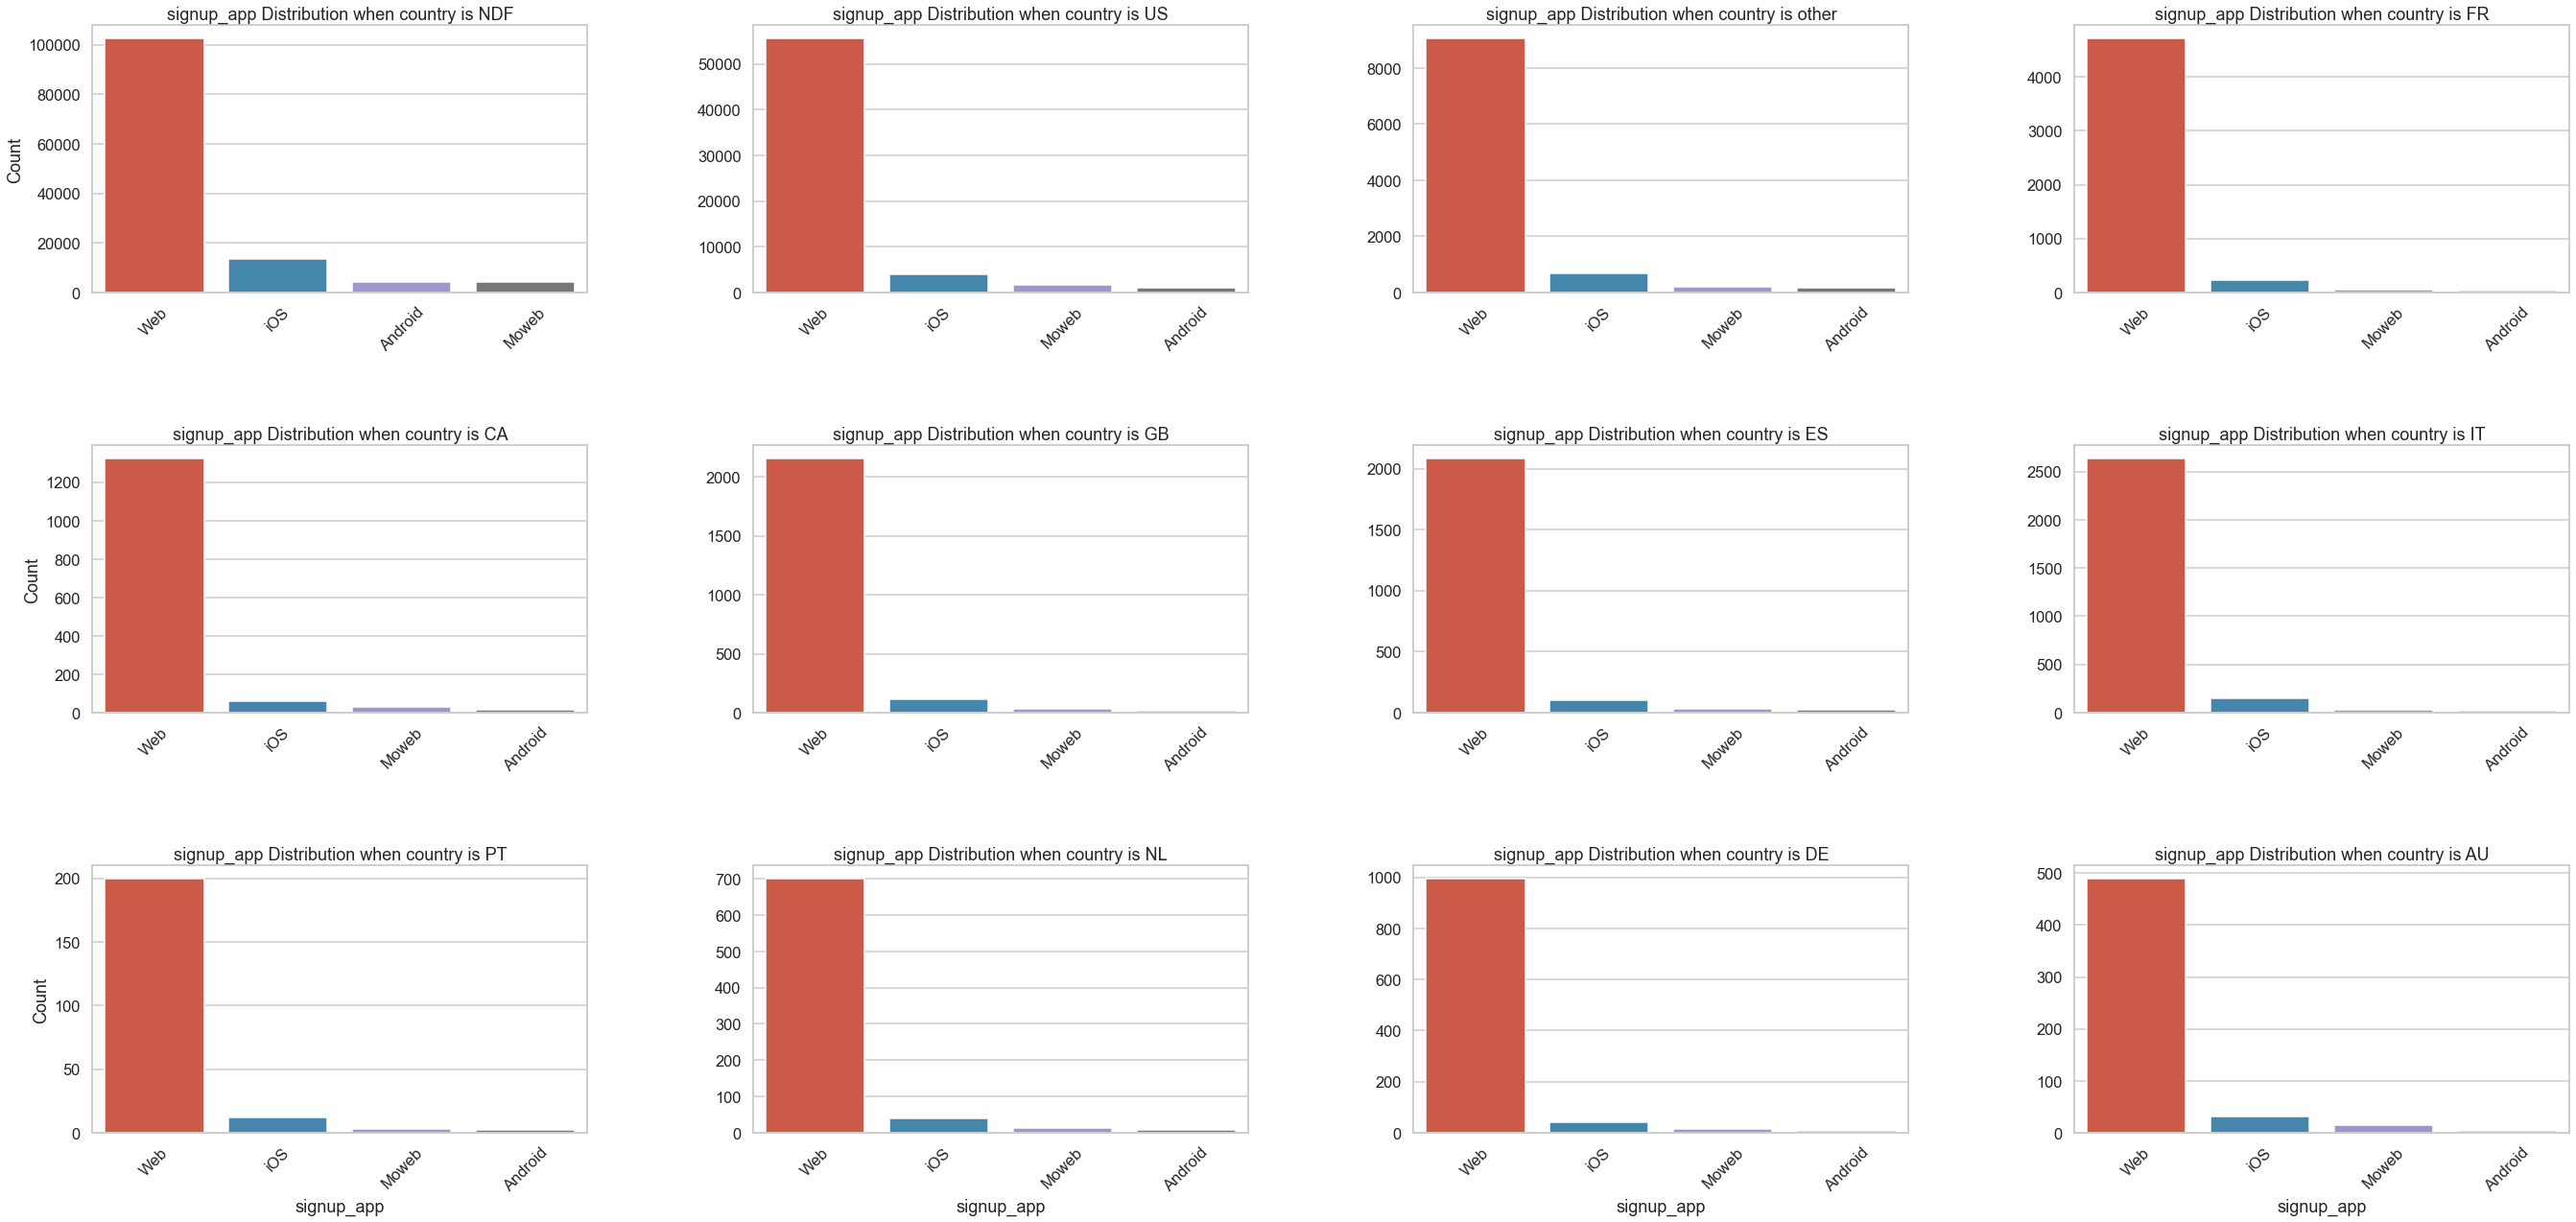

In [61]:
## figure
fig, ax = plt.subplots(3, 4, figsize=(40, 20))
fig.tight_layout(pad=7)  

for i in range(3):
    for j in range(4):
        plt.sca(ax[i, j])
        to_plot_each = df_train[df_train['country_destination']==dstn_uniq[i, j]]['signup_app']

        sns.countplot(to_plot_each, order=to_plot_each.value_counts().index)
        plt.title(f'signup_app Distribution when country is {dstn_uniq[i, j]}')
        plt.xticks(rotation=45)
        if i==2:
            plt.xlabel('signup_app')
        else:
            plt.xlabel('')
        if j==0:
            plt.ylabel('Count')
        else:
            plt.ylabel('')

> ### Comment: It seems that no big difference, I will wait to get the importance features using model

--------

### `first_device_type Distribution for each Country`

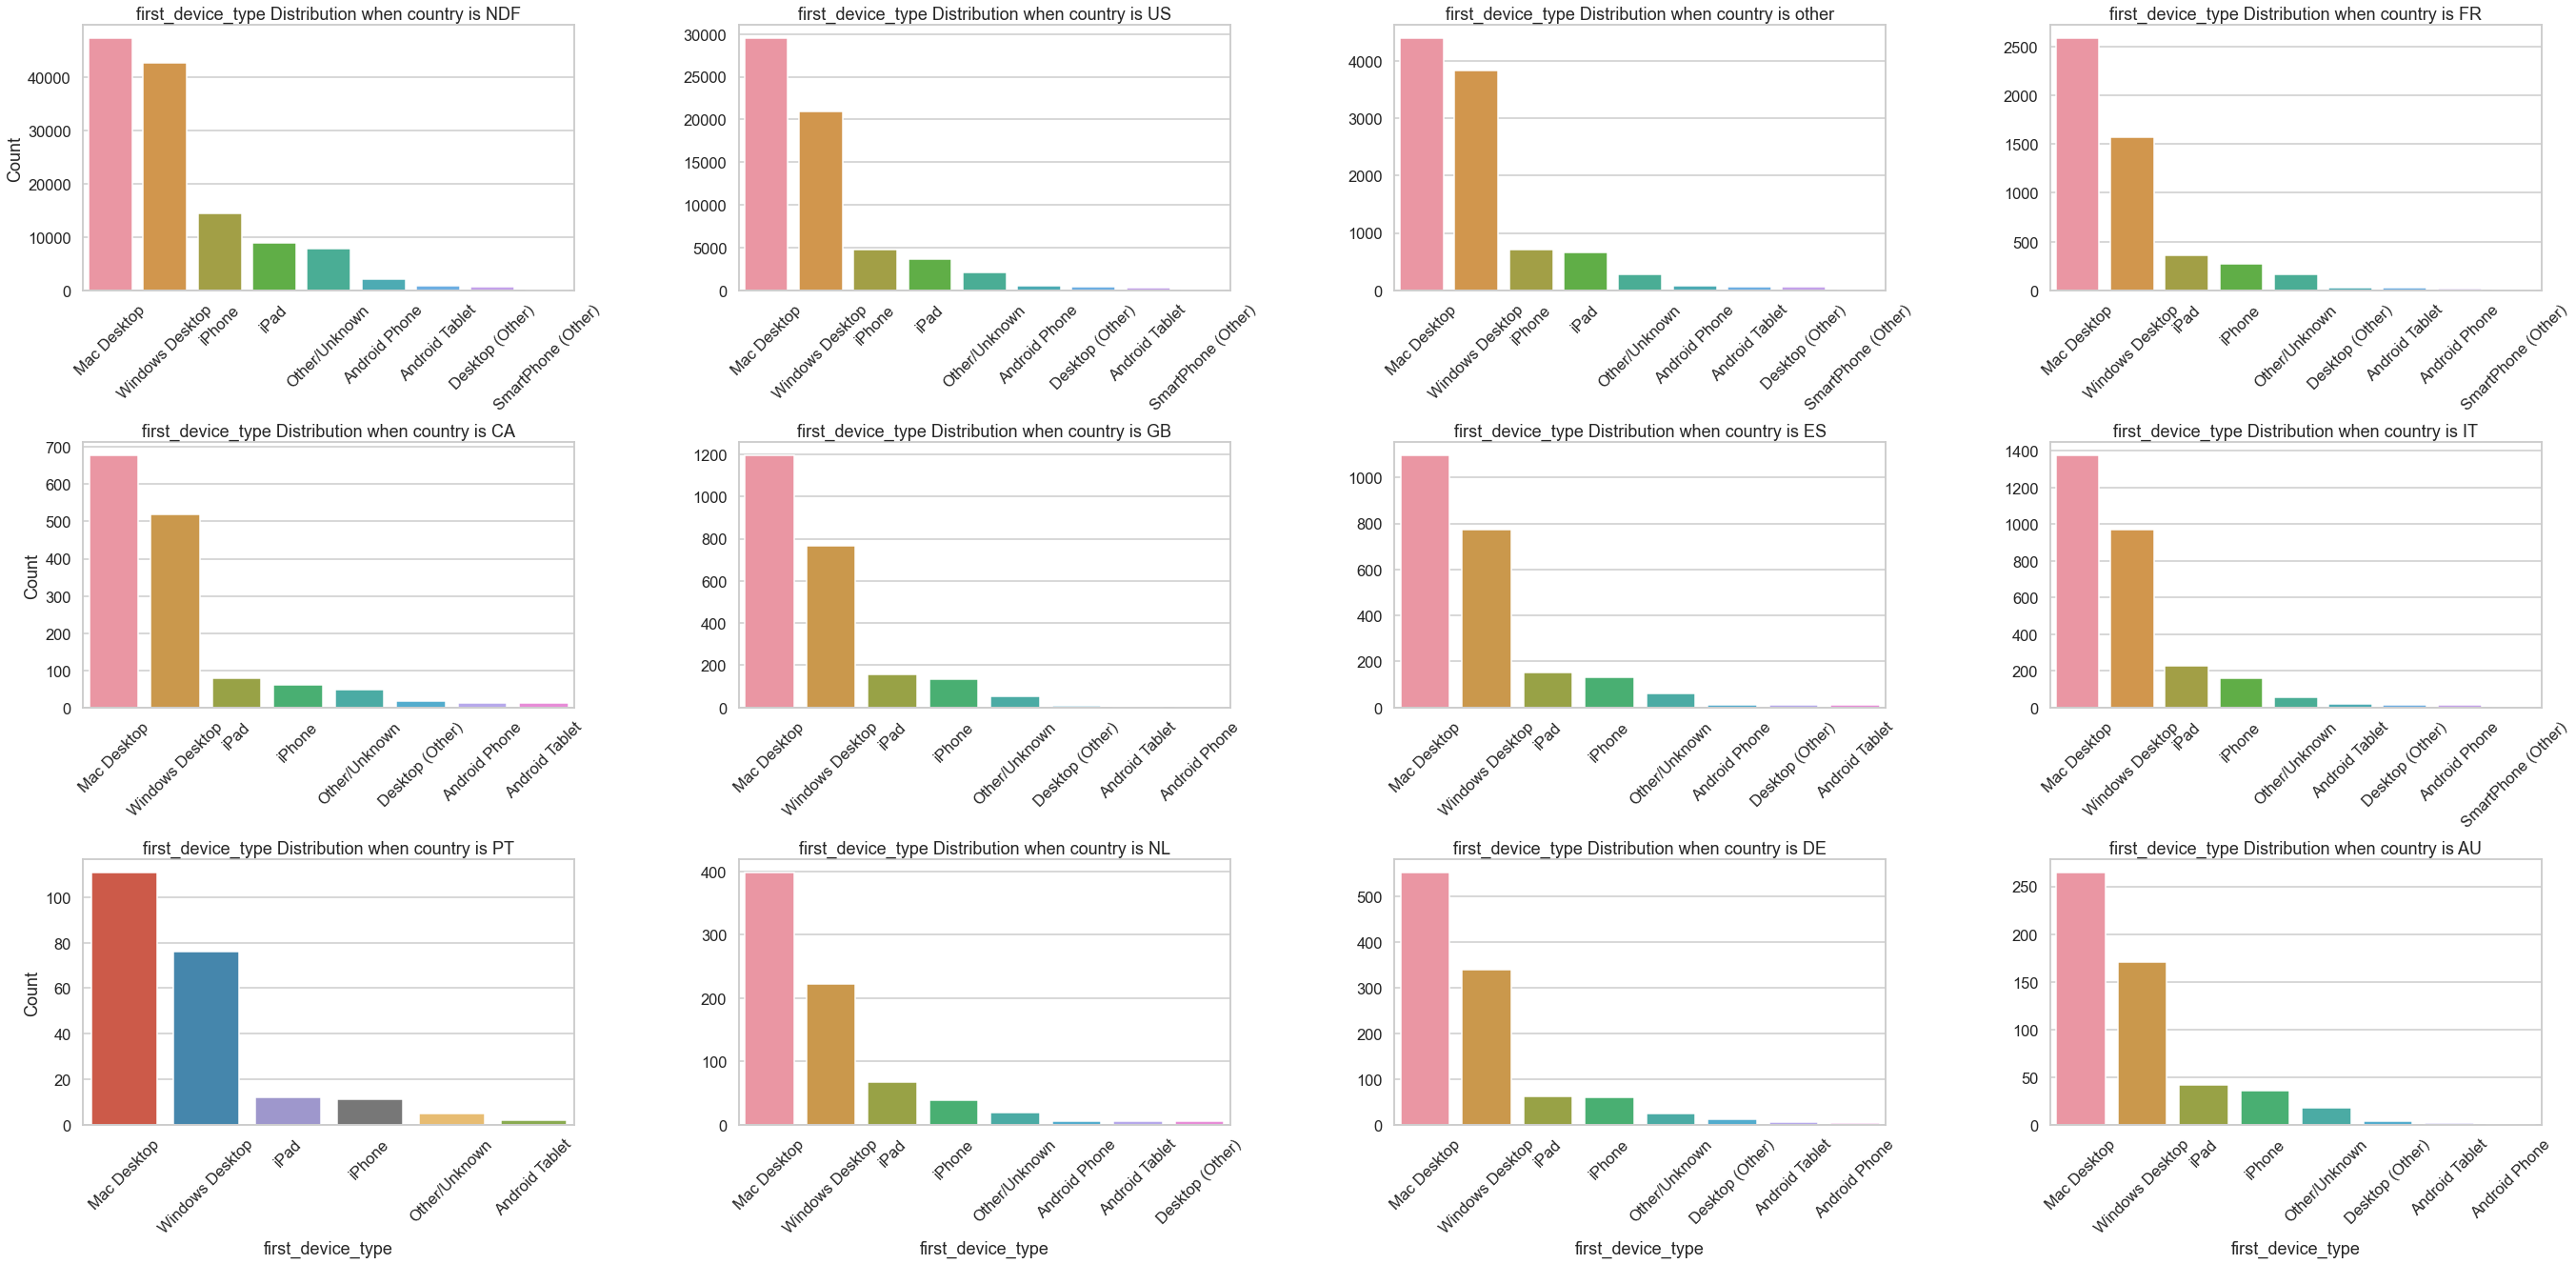

In [62]:
## figure
fig, ax = plt.subplots(3, 4, figsize=(40, 20))
fig.tight_layout(pad=7)  

for i in range(3):
    for j in range(4):
        plt.sca(ax[i, j])
        to_plot_each = df_train[df_train['country_destination']==dstn_uniq[i, j]]['first_device_type']

        sns.countplot(to_plot_each, order=to_plot_each.value_counts().index)
        plt.title(f'first_device_type Distribution when country is {dstn_uniq[i, j]}')
        plt.xticks(rotation=45)
        if i==2:
            plt.xlabel('first_device_type')
        else:
            plt.xlabel('')
        if j==0:
            plt.ylabel('Count')
        else:
            plt.ylabel('')

> ### Comment: It seems that no big difference, I will wait to get the importance features using model

-----

### `Multivariate Visualization`

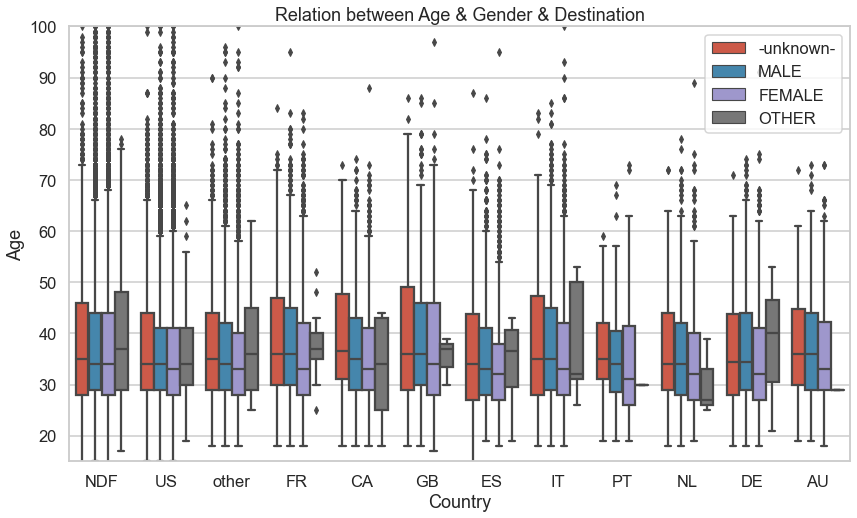

In [63]:
## Relation between Age & Gender & Destination
plt.figure(figsize=(14, 8))

sns.boxplot(data=df_train, y='age', x='country_destination', hue='gender');
plt.ylim(15, 100)
plt.xlabel('Country')
plt.ylabel('Age')
plt.title('Relation between Age & Gender & Destination')
plt.legend(loc='upper right')
plt.show()

> ### Comment: It seems that there are outliers in (US & IT & FR) much more than other Destination as I said before, It also seems that variance for gender(Male, Female, unknown) are almost typical in the same Destination, but gender(other) is mort different and its variance is bigger in some Destinations and less in other, It may happen because gender (Other) appears not much in this Dataset compared to other genders.

----------

## Splitting the train Dataset to (train, valid)
* `In order to be able to make some Tuning for Models Hyperparameters`  <br />
* `Using the Stratified Method of Sampling for taking equal ratio for target (country_destination)`

In [64]:
df_train_full = df_train.copy()

## create the generator
split_data = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
gen_for_indecies = split_data.split(df_train_full, df_train_full['country_destination'])

## loop over generator
for train_idx, valid_idx in gen_for_indecies:
    train_set = df_train_full.iloc[train_idx]
    valid_set = df_train_full.iloc[valid_idx]
    
## train
X_train = train_set.drop(columns=['country_destination'], axis=1)
y_train = train_set['country_destination']

## valid
X_valid = valid_set.drop(columns=['country_destination'], axis=1)
y_valid = valid_set['country_destination']



## for train and valid
print('X_train.shape -->', X_train.shape)
print('y_train.shape -->', y_train.shape)

print('***'*10)

print('X_valid.shape -->', X_valid.shape)
print('y_valid.shape -->', y_valid.shape)

print('***'*10)

X_train.shape --> (160088, 15)
y_train.shape --> (160088,)
******************************
X_valid.shape --> (53363, 15)
y_valid.shape --> (53363,)
******************************


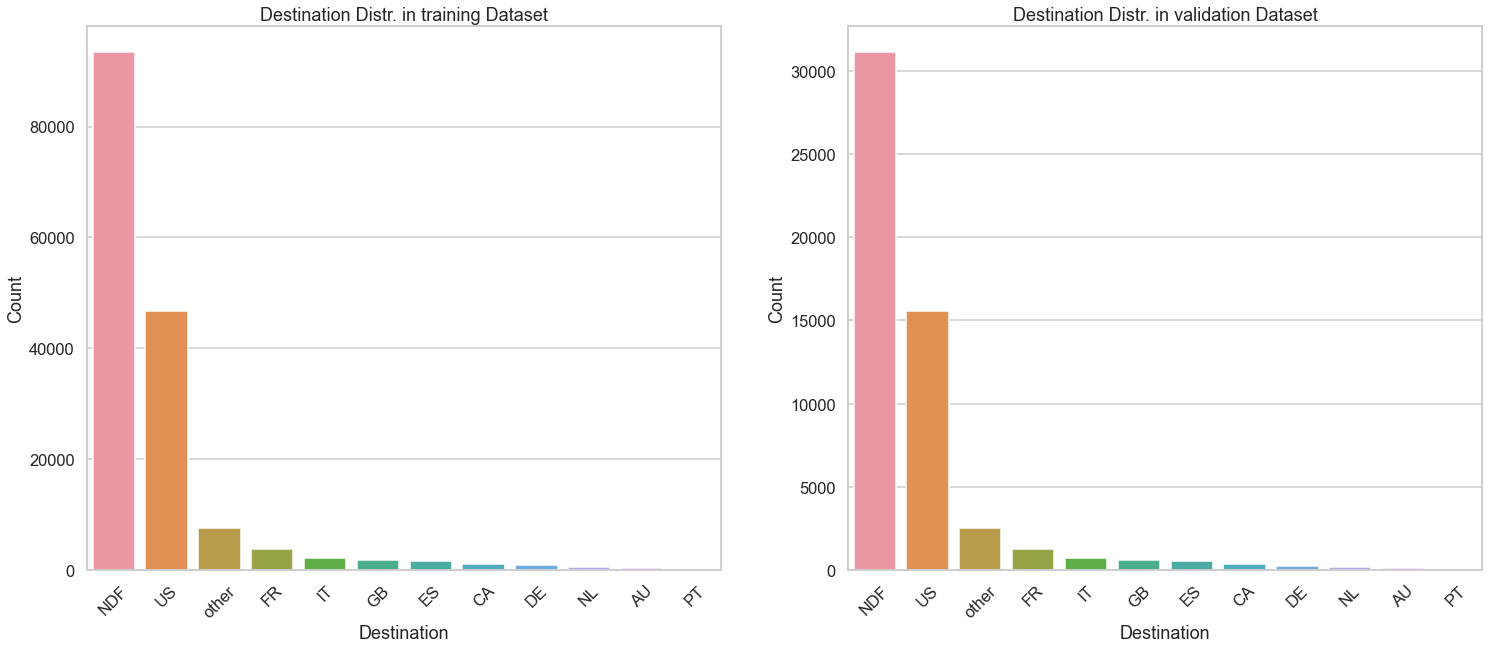

In [65]:
## let's check our results with visualization
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

plt.sca(ax[0])
sns.countplot(x='country_destination', data=train_set, order=train_set['country_destination'].value_counts().index)
plt.title('Destination Distr. in training Dataset')
plt.xticks(rotation=45)
plt.xlabel('Destination')
plt.ylabel('Count')

plt.sca(ax[1])
sns.countplot(x='country_destination', data=valid_set, order=valid_set['country_destination'].value_counts().index)
plt.title('Destination Distr. in validation Dataset')
plt.xticks(rotation=45)
plt.xlabel('Destination')
plt.ylabel('Count')

plt.show()   ## That Exactly what I want to do

## Feature Engineering

> ###  Comment: Adding New Features, as I found that months and years are important in predicting the Destination, I extracted (year, month, day) from (date_account_created) feature, and did the same for (timestamp_first_active) feature, For irrelevant Features, let the model get the importance of features, Handling numerical features by imputing then scalin, Handling categorical features by imputing then one-hot encoding, Concatenating both numerical and categorical processed features.


In [66]:
def feature_eng(df):
    ''' This Function tries to process the dataframe, adding new features, handling outliers in age column.
    Args:
    -----
        (df: DataFrame) : The desired DataFrame which I want to be processed

    Returns:
    --------
        (df: DataFrame): The finally processed DataFrame, with Feature Engineering
    '''
    
    if 'country_destination' in df.columns:  ## only if training data there is a taget
        df = df.drop(columns=['country_destination'], axis=1)
        
    df = df.drop(columns=['id', 'date_first_booking'], axis=1)
    
    ## date_account_created --> Extracting ne Features
    date_account = np.vstack(df['date_account_created'].astype(str)\
                                             .apply(lambda x: list(map(int, x.split('-')))).values)
    df['dac_year'] = date_account[:, 0]
    df['dac_month'] = date_account[:, 1]
    df['dac_day'] = date_account[:, 2]
    df = df.drop(columns=['date_account_created'], axis=1)  ## drop it now
    
    
    ## timestamp_first_active  --> Extracting ne Features
    time_first_act = np.vstack(df['timestamp_first_active'].astype(str)\
                            .apply(lambda x: list(map(int, [x[:4], x[4:6], x[6:8], x[8:10], x[10:12], x[12:14]]))).values)

    df['tfa_year'] = time_first_act[:, 0]
    df['tfa_month'] = time_first_act[:, 1]
    df['tfa_day'] = time_first_act[:, 2]
    df = df.drop(['timestamp_first_active'], axis=1)      ## drop it now

    
    ## checking for Age column as I dis in EDA
    ## Handle the age to be nan if it is bigger than 100 years or less than 15 years
    df[df['age']>=100]=np.nan
    df[df['age']<15]=np.nan
    
    df['age'] = np.log(df['age'])  ## take log for this feature

    return df

### `For training Dataset`

In [67]:
## call the (feature_eng) function to process the feature in the desired way
X_train_feat = feature_eng(X_train)  ## calling the function


## numerical --> imputing  and scaling
num_cols = [cname for cname in X_train_feat.columns if
                        X_train_feat[cname].dtype in ['int64','float64', 'int32', 'float32']] 
categ_cols = [cname for cname in X_train_feat.columns if
                        X_train_feat[cname].dtype not in ['int64','float64', 'int32', 'float32']]

print('Chossen Numerical Features: \n', num_cols)
print('**'*50)
print('Chossen Categorical Features: \n', categ_cols)

## Create the Pipeline for numerical values
num_pipline = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
                ('scaler', StandardScaler())
                    ])
X_train_num = num_pipline.fit_transform(X_train_feat[num_cols])

## Create the Pipeline for categorical values 
categ_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
                    ])
categ_transform = ColumnTransformer(
                    transformers=[
                        ('cat', categ_pipeline, categ_cols)
                    ])
X_train_categ = categ_transform.fit_transform(X_train_feat[categ_cols])

## concatenate and to DataFrame
X_train_final = np.concatenate((X_train_num, X_train_categ), axis=1)
X_train_final = pd.DataFrame(X_train_final)


Chossen Numerical Features: 
 ['age', 'signup_flow', 'dac_year', 'dac_month', 'dac_day', 'tfa_year', 'tfa_month', 'tfa_day']
****************************************************************************************************
Chossen Categorical Features: 
 ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']


In [68]:
## For target --> LabelEncoder --> for training 
label_enc = LabelEncoder()
y_train_encoded = label_enc.fit_transform(y_train)


## then target --> LabelBinarizer --> to get the ndcg_score
label_bin = LabelBinarizer()
y_train_final = label_bin.fit_transform(y_train_encoded)

### `For validation Dataset`

In [69]:
## call the (feature_eng) function to process the feature in the desired way
X_valid_feat = feature_eng(X_valid)  ## calling the function

X_valid_num = num_pipline.transform(X_valid_feat[num_cols])

X_valid_categ = categ_transform.transform(X_valid_feat[categ_cols])

## concatenate and to DataFrame
X_valid_final = np.concatenate((X_valid_num, X_valid_categ), axis=1)
X_valid_final = pd.DataFrame(X_valid_final)


## For target --> LabelEncoder
y_valid_encoded = label_enc.transform(y_valid)

## then taget --> LabelBinarizer
y_valid_final = label_bin.transform(y_valid_encoded)

### `For testing Dataset`

In [70]:
## call the (feature_eng) function to process the feature in the desired way
X_test_feat = feature_eng(df_test)  ## calling the function

X_test_num = num_pipline.transform(X_test_feat[num_cols])

X_test_categ = categ_transform.transform(X_test_feat[categ_cols])

## concatenate and to DataFrame
X_test_final = np.concatenate((X_test_num, X_test_categ), axis=1)
X_test_final = pd.DataFrame(X_test_final)

In [71]:
## check shapes of all datasets
print('X_train_final.shape -->', X_train_final.shape)
print('y_train_encoded.shape -->', y_train_encoded.shape)

print('**'*20)

print('X_valid_final.shape -->', X_valid_final.shape)
print('y_valid_encoded.shape -->', y_valid_encoded.shape)

print('**'*20)

print('X_test_final.shape -->', X_test_final.shape)

X_train_final.shape --> (160088, 142)
y_train_encoded.shape --> (160088,)
****************************************
X_valid_final.shape --> (53363, 142)
y_valid_encoded.shape --> (53363,)
****************************************
X_test_final.shape --> (62096, 142)


## Building ML Models

### Evaluation metric is 'ndcg_score'

* `y_true --> works as gain`
* `y_score --> used for sorting y_true`
* `we are calculating using y_true but sorted by y_scores`

### `Building a custom function for Tuning to be passed to GridSearchCV`

Found [Here](https://www.kaggle.com/davidgasquez/ndcg-scorer)

In [72]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer


def dcg_score_func(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score_func(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score_func(y_true, y_score, k)
        best = dcg_score_func(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score_func, needs_proba=True, k=5)

### `Dealing with unbalanced taget`

`Increasing the weights of underrepresented classes and decrease the weights of overrepresented calsses`

In [73]:
## count each
vals_count = np.bincount(y_train_encoded)/y_train_encoded.shape[0]
## inverse
vals_count = 1 - vals_count
## normalize
new_vals = vals_count/sum(vals_count)   

dict_weights = {}
for i in range(12):
    dict_weights[i] = new_vals[i]
    
dict_weights

{0: 0.09067967163514612,
 1: 0.09030090268534124,
 2: 0.09045706679508089,
 3: 0.08995109507952444,
 4: 0.08876992654040278,
 5: 0.08991929438808656,
 6: 0.08970180037343098,
 7: 0.03786610546017872,
 8: 0.09058426956083244,
 9: 0.09081652818222705,
 10: 0.06434302042967277,
 11: 0.086610318870076}

### `1. LogisticRegression`
`After Finishing the Model an take screens, I downloaded the model and make this cell as markdown to not take much time in running`

In [ ]:

## logit_clf
logit_clf = LogisticRegression(class_weight=dict_weights)
logit_clf.fit(X_train_final, y_train_encoded)

## prediction
y_pred_train_logit = logit_clf.predict_proba(X_train_final)
y_pred_valid_logit = logit_clf.predict_proba(X_valid_final)


## calculate ndcg_score
score_train_logit = ndcg_score(y_true=y_train_final, y_score=y_pred_train_logit, 
                               k=5, sample_weight=None, ignore_ties=False)

score_valid_logit = ndcg_score(y_true=y_valid_final, y_score=y_pred_valid_logit, 
                               k=5, sample_weight=None, ignore_ties=False)

print('score for training :', score_train_logit)
print('score for validation :', score_valid_logit)


``` python
## Download the Model
joblib.dump(logit_clf, 'logit_clf.pkl')
```

### `Load the Logistic Model`

In [74]:
## loading the Model, which we saved to not take much time while rerunning the notebook 
logit_clf = joblib.load('logit_clf.pkl')

---------

### `2. RandomForest`
`After Finishing the Model an take screens, I downloaded the model and make this cell as markdown to not take much time in running`

``` python
## forest_clf
forest_clf = RandomForestClassifier(n_estimators=50, max_depth=10, class_weight=dict_weights, random_state=42)
forest_clf.fit(X_train_final, y_train_encoded)


## prediction
y_pred_train_forest = forest_clf.predict_proba(X_train_final)
y_pred_valid_forest = forest_clf.predict_proba(X_valid_final)


## calculate ndcg_score
score_train_forest = ndcg_score(y_true=y_train_final, y_score=y_pred_train_forest, 
                               k=5, sample_weight=None, ignore_ties=False)

score_valid_forest = ndcg_score(y_true=y_valid_final, y_score=y_pred_valid_forest, 
                                k=5, sample_weight=None, ignore_ties=False)


print('score for training :', score_train_forest)
print('score for validation :', score_valid_forest)
```

``` python
## Download the Model
joblib.dump(forest_clf, 'forest_clf.pkl')
```

### `Load the RandomForest Model`

In [75]:
## loading the Model, which we saved to not take much time while rerunning the notebook 
forest_clf = joblib.load('forest_clf.pkl')

### `Example on how to calcualte ndcg & dcg`

In [76]:
## prediction
y_pred_train_forest = forest_clf.predict_proba(X_train_final)
y_pred_valid_forest = forest_clf.predict_proba(X_valid_final)

In [77]:
scores = y_pred_valid_forest[[6, 8]]
scores

array([[0.00473584, 0.01241849, 0.01149762, 0.01920588, 0.04091709,
        0.01999815, 0.02197729, 0.37530294, 0.00937925, 0.00202969,
        0.39137663, 0.09116112],
       [0.00242518, 0.01681897, 0.00564188, 0.01748346, 0.03609629,
        0.01189522, 0.0144351 , 0.60742774, 0.00619956, 0.00532929,
        0.22908344, 0.04716386]])

In [78]:
trues = y_valid_final[[6, 8]]
trues

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [79]:
print('dcg_score :', dcg_score(y_true=trues, y_score=scores, k=5))
print('ndcg_score :', ndcg_score(y_true=trues, y_score=scores, k=5))

dcg_score : 0.8154648767857287
ndcg_score : 0.8154648767857287


--------

### `3. KNN`

`After Finishing the Model an take screens, I downloaded the model and make this cell as markdown to not take much time in running`

``` python
## knn_clf
knn_clf = KNeighborsClassifier(n_neighbors=100)
knn_clf.fit(X_train_final, y_train_encoded)

## prediction
y_pred_train_knn = knn_clf.predict_proba(X_train_final)
y_pred_valid_knn = knn_clf.predict_proba(X_valid_final)


## calculate ndcg_score
score_train_knn = ndcg_score(y_true=y_train_final, y_score=y_pred_train_knn, 
                               k=5, sample_weight=None, ignore_ties=False)

score_valid_knn = ndcg_score(y_true=y_valid_final, y_score=y_pred_valid_knn, 
                                k=5, sample_weight=None, ignore_ties=False)

print('score for training :', score_train_knn)
print('score for validation :', score_valid_knn)
``` 

``` python
## Download the Model
joblib.dump(knn_clf, 'knn_clf.pkl')
```

### `Load the KNN Model`

In [80]:
## loading the Model, which we saved to not take much time while rerunning the notebook 
knn_clf = joblib.load('knn_clf.pkl')

------------

### `4. xgboost`
`After Finishing the Model an take screens, I downloaded the model and make this cell as markdown to not take much time in running`

``` python
## xgb_clf
xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
                       learning_rate=0.1, max_delta_step=0, max_depth=3,
                       min_child_weight=1, n_estimators=200, n_jobs=-1, 
                       objective='multi:softmax',
                       reg_lambda=1, subsample=1, random_state=0)

xgb_clf.fit(X_train_final, y_train_encoded)


## Prediction
y_pred_train_xgb = xgb_clf.predict_proba(X_train_final)
y_pred_valid_xgb = xgb_clf.predict_proba(X_valid_final)

## calculate ndcg_score
score_train_xgb = ndcg_score(y_true=y_train_final, y_score=y_pred_train_xgb, 
                               k=5, sample_weight=None, ignore_ties=False)

score_valid_xgb = ndcg_score(y_true=y_valid_final, y_score=y_pred_valid_xgb, 
                               k=5, sample_weight=None, ignore_ties=False)


print('score for training :', score_train_xgb)
print('score for validation :', score_valid_xgb)
``` 

### `Get Feature Importance `

``` python
## Download the Model
joblib.dump(xgb_clf, 'xgb_clf.pkl')
```

In [81]:
## loading the Model, which we saved to not take much time while rerunning the notebook 
xgb_clf = joblib.load('xgb_clf.pkl')

In [82]:
## get and sort 
feat_import = xgb_clf.get_booster().get_score(importance_type='weight')
feat_import = pd.DataFrame.from_dict(feat_import, orient='index')
feat_import = feat_import.reset_index()
feat_import = feat_import.rename(columns={'index': 'feature', 0: 'score'})

feat_import['feature'] = feat_import['feature'].astype('int64')
df_feat_import = feat_import.sort_values(by='score', ascending=False)

df_feat_import  ## dataframe of features with each f1_score

,feature,score
0,0,2713.0
1,3,1091.0
2,4,947.0
3,1,883.0
4,2,871.0
...,...,...
84,26,2.0
85,38,2.0
86,135,2.0
87,97,1.0


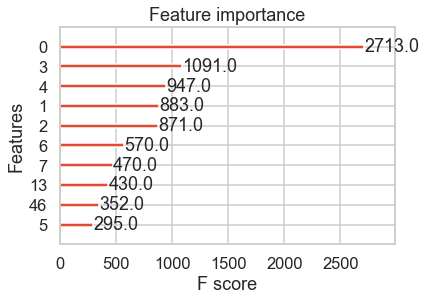

In [83]:
## Let's plot the first importatnt 10 featurs
plot_importance(xgb_clf, max_num_features=10);

In [84]:
feat_import = df_feat_import['feature'].tolist()

feat_import  ## list od important columns to be used and train the model again

[0,
 3,
 4,
 1,
 2,
 6,
 7,
 13,
 46,
 5,
 85,
 10,
 14,
 9,
 8,
 49,
 72,
 76,
 89,
 74,
 41,
 43,
 69,
 20,
 82,
 108,
 112,
 90,
 79,
 22,
 56,
 100,
 88,
 48,
 63,
 78,
 92,
 53,
 130,
 25,
 73,
 29,
 58,
 119,
 50,
 47,
 23,
 75,
 77,
 33,
 86,
 52,
 84,
 65,
 36,
 80,
 54,
 31,
 42,
 83,
 98,
 101,
 57,
 60,
 67,
 122,
 11,
 102,
 37,
 55,
 99,
 59,
 132,
 113,
 35,
 15,
 44,
 64,
 94,
 93,
 30,
 70,
 71,
 21,
 26,
 38,
 135,
 97,
 40]

In [85]:
## slice only the important features
X_train_import = X_train_final.iloc[:, feat_import]
X_valid_import = X_valid_final.iloc[:, feat_import]

### `Train the Model again`

In [86]:
## xgb_clf
xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
                       learning_rate=0.1, max_delta_step=0, max_depth=3,
                       min_child_weight=1, n_estimators=200, n_jobs=-1, 
                       objective='multi:softmax',
                       reg_lambda=1, subsample=1, random_state=0)

xgb_clf.fit(X_train_import, y_train_encoded)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [87]:
## Prediction
y_pred_train_xgb = xgb_clf.predict_proba(X_train_import)
y_pred_valid_xgb = xgb_clf.predict_proba(X_valid_import)

## calculate ndcg_score
score_train_xgb = ndcg_score(y_true=y_train_final, y_score=y_pred_train_xgb, 
                               k=5, sample_weight=None, ignore_ties=False)

score_valid_xgb = ndcg_score(y_true=y_valid_final, y_score=y_pred_valid_xgb, 
                               k=5, sample_weight=None, ignore_ties=False)


print('score for training :', score_train_xgb)
print('score for validation :', score_valid_xgb)

score for training : 0.8280778286934459
score for validation : 0.8245730835676537


## `Tuning`

``` python
## Hyperparameters Tuning  (with some trials add and delte unitl I finished tuning)
params_best_xgb = {'learning_rate': [0.09, 0.1],
                  'n_estimators': [150, 250, 300], 
                   'max_depth': [4, 5, 6]}

### using GridSearchCV
grid_xgb = GridSearchCV(xgb_clf, param_grid=params_best_xgb, cv=5, 
                        scoring=ndcg_scorer, n_jobs=-1, verbose=30)

grid_xgb.fit(X_train_final, y_train_encoded)

## best model
xgb_best_clf = grid_xgb.best_estimator_

print('xgb_best_clf =>', xgb_best_clf)
print('=='*20)

## Prediction
y_pred_train_xgb = xgb_best_clf.predict_proba(X_train_final)
y_pred_valid_xgb = xgb_best_clf.predict_proba(X_valid_final)

## calculate ndcg_score
score_train_xgb = ndcg_score(y_true=y_train_final, y_score=y_pred_train_xgb, 
                               k=5, sample_weight=None, ignore_ties=False)

score_valid_xgb = ndcg_score(y_true=y_valid_final, y_score=y_pred_valid_xgb, 
                               k=5, sample_weight=None, ignore_ties=False)


print('score for training :', score_train_xgb)
print('score for validation :', score_valid_xgb)
```

``` python
## Download the Model
joblib.dump(xgb_clf, 'xgb_clf.pkl')
```

### `Load the xgboost Model`

In [88]:
## loading the Model, which we saved to not take much time while rerunning the notebook 
xgb_clf = joblib.load('xgb_clf.pkl')

----------------

### `ALL Models`
`After Finishing the Model an take screens, I downloaded the model and make this cell as markdown to not take much time in running`

``` python
## I Will loop over all classification Algorithms , which i build above >> then take the max results

best_models = [logit_clf, forest_clf, knn_clf, gauss_clf, xgb_clf]

for clf in best_models:
    clf.fit(X_train_final, y_train_encoded)
    
    y_pred_each_train = clf.predict_proba(X_train_final)
    y_pred_each_valid = clf.predict_proba(X_valid_final)
    
    print(clf.__class__.__name__, ':')
    ## calculate ndcg_score
    score_train_each = ndcg_score(y_true=y_train_final, y_score=y_pred_each_train, 
                                   k=5, sample_weight=None, ignore_ties=False)

    score_valid_each = ndcg_score(y_true=y_valid_final, y_score=y_pred_each_valid, 
                                   k=5, sample_weight=None, ignore_ties=False)

    
    print(" Training score: ", score_train_each)
    print(" Validation score: ", score_valid_each)
    print('==='*15)
```

--------------------

## Inference on test Dataset
`We had processed the Dataset before, now Inference`

In [89]:
## slice only important features
X_test_import = X_test_final.iloc[:, feat_import]

In [90]:
## Inference for test_set
y_pred_test_xgb = xgb_clf.predict_proba(X_test_import)
y_pred_test_xgb

array([[0.00192975, 0.00417778, 0.00208261, ..., 0.00136013, 0.34799793,
        0.03054911],
       [0.00098691, 0.00269324, 0.00067511, ..., 0.00088818, 0.12317304,
        0.02991152],
       [0.00098147, 0.00439541, 0.00106819, ..., 0.00103265, 0.1663315 ,
        0.06483515],
       ...,
       [0.00077894, 0.00108852, 0.01013891, ..., 0.00066463, 0.13491714,
        0.05396032],
       [0.00096617, 0.0034008 , 0.00150149, ..., 0.00055273, 0.13031353,
        0.02644395],
       [0.00318201, 0.01030315, 0.00262072, ..., 0.00130927, 0.41557387,
        0.0478678 ]], dtype=float32)

In [91]:
## two lists one for ids, and one for countries (each id has 5 countries)
ids_test = []  
dest_test = []  
for i in range(len(df_test)):
    idx = df_test['id'].iloc[i]
    ids_test += [idx] * 5
    dest_test += label_enc.inverse_transform(np.argsort(y_pred_test_xgb[i])[::-1])[:5].tolist()
    
## concatenate the both columns
submit_test = pd.DataFrame(np.column_stack((ids_test, dest_test)), columns=['id', 'country'])

submit_test

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,ES
...,...,...
310475,9uqfg8txu3,NDF
310476,9uqfg8txu3,US
310477,9uqfg8txu3,other
310478,9uqfg8txu3,FR


In [92]:
submit_test.to_csv('submit.csv', index=False)

----------

## `Deep Learning Model using ANN`

In [93]:
## It is enough for deep learning (float32)
## train
X_train_deep = X_train_final.astype('float32')
## valid
X_valid_deep = X_valid_final.astype('float32')
## test
X_test_deep = X_test_final.astype('float32')


## encoding for taregt to work in network (one hot encoding)
y_train_deep = tf.keras.utils.to_categorical(y_train_encoded)
y_valid_deep = tf.keras.utils.to_categorical(y_valid_encoded)

print('X_train_deep.shape ', X_train_deep.shape)
print('y_train_deep.shape ', y_train_deep.shape)
print('X_valid_deep.shape ', X_valid_deep.shape)
print('y_valid_deep.shape ', y_valid_deep.shape)
print('X_test_deep.shape ', X_test_deep.shape)

X_train_deep.shape  (160088, 142)
y_train_deep.shape  (160088, 12)
X_valid_deep.shape  (53363, 142)
y_valid_deep.shape  (53363, 12)
X_test_deep.shape  (62096, 142)


In [ ]:
## Create a Netwrok

model_deep = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='selu', kernel_initializer='lecun_normal', input_shape=(142,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(12, activation='softmax')
    
])

model_deep.summary()

In [ ]:
## use Exponential Decay 
n_epochs = 30
n_batch_sz = 32

s = n_epochs * len(X_train_deep) // n_batch_sz  
lr_schedular = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, 
                                                              decay_steps=s, decay_rate=0.1)
optimizer_with_lr = tf.keras.optimizers.Adam(learning_rate=lr_schedular)


## compile Model
model_deep.compile(loss=tfr.keras.losses.ApproxNDCGLoss(), 
                   optimizer=optimizer_with_lr, 
                   metrics=tfr.keras.metrics.NDCGMetric(topn=5))




early_stopp = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_ndcg_metric_4')

## train the Model
history = model_deep.fit(X_train_deep, y_train_deep, 
                         validation_data=(X_valid_deep, y_valid_deep), 
                         epochs=n_epochs, batch_size=n_batch_sz, 
                         callbacks=[early_stopp], class_weight=dict_weights)

In [ ]:
## Evaluation
loss_train, score_train = model_deep.evaluate(X_train_deep, y_train_deep)
loss_valid, score_valid = model_deep.evaluate(X_valid_deep, y_valid_deep)

print('score_train :', score_train)
print('**'*10)
print('score_valid :', score_valid)

In [ ]:
## save the model
model_deep.save('model_deep.h5')

In [ ]:
## load the model
model_deep = tf.keras.models.load_model('model_deep.h5')

## `Inference on test Dataset`

In [ ]:
## Inference for test_set
y_pred_test_deep = model_deep.predict(X_test_deep)
y_pred_test_deep

In [ ]:
## two lists one for ids, and one for countries (each id has 5 countries)
ids_test = []  
dest_test = []  
for i in range(len(df_test)):
    idx = df_test['id'].iloc[i]
    ids_test += [idx] * 5
    dest_test += label_enc.inverse_transform(np.argsort(y_pred_test_deep[i])[::-1])[:5].tolist()
    
## concatenate the both columns
submit_test = pd.DataFrame(np.column_stack((ids_test, dest_test)), columns=['id', 'country'])

submit_test

In [ ]:
submit_test.to_csv('submit.csv', index=False)

## Done!